# Modules and Import

In [1]:
# Import necessary libraries
import scipy.io
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree

# Define all parameters and constants at the beginning
RANDOM_STATE = 42
TEST_SIZE = 0.2
MINORITY_CLASS = 1
CONFIDENCE_THRESHOLD = 0.7
MAX_DEPTH = [3, 5, 7]
MIN_SAMPLES_SPLIT = [2, 4]
MIN_SAMPLES_LEAF = [1, 3]
CRITERION = ['gini', 'entropy']
CV_FOLDS = 10
SCORING = 'accuracy'
N_JOBS = -1

# Helper function to apply blue text formatting
def blue_text(text):
    return f"\033[1m\033[94m{text}\033[0m"

# Path to dataset
base_path = '/Users/asifahmed/Documents/Codes/MyRecourseProject/datasets/ACES_dataset'

# Step 1: Load the dataset
def load_and_prepare_aces_data(base_path):
    expression_data = scipy.io.loadmat(f'{base_path}/ACES_RefinedCommunity_AVG.mat')
    label_data = scipy.io.loadmat(f'{base_path}/ACESLabel.mat')
    expression_matrix = expression_data['data']
    labels = label_data['label'].flatten()
    expression_df = pd.DataFrame(expression_matrix)
    labels_df = pd.Series(labels, name='label')
    return expression_df, labels_df

# Step 2: Split the dataset
def split_data(expression_df, labels_df, test_size=TEST_SIZE, random_state=RANDOM_STATE):
    X_train, X_test, y_train, y_test = train_test_split(expression_df, labels_df, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

# Step 3: Perform hyperparameter tuning
def perform_grid_search(X_train, y_train, random_state=RANDOM_STATE, cv=CV_FOLDS, scoring=SCORING, n_jobs=N_JOBS):
    param_grid = {
        'max_depth': MAX_DEPTH,
        'min_samples_split': MIN_SAMPLES_SPLIT,
        'min_samples_leaf': MIN_SAMPLES_LEAF,
        'criterion': CRITERION
    }
    
    dt = DecisionTreeClassifier(random_state=random_state)
    grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=cv, scoring=scoring, n_jobs=n_jobs)
    grid_search.fit(X_train, y_train)
    return grid_search

# Step 4: Train the model using the best parameters
def train_best_model(grid_search, X_train, y_train):
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)
    return best_model

# Step 5: Adjusting Decision Threshold
def find_optimal_threshold(model, X, y, cv=CV_FOLDS, random_state=RANDOM_STATE):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    y_proba = np.zeros(len(y))

    for train_index, val_index in skf.split(X, y):
        X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
        y_train_cv = y.iloc[train_index]

        model_clone = clone(model) 
        model_clone.fit(X_train_cv, y_train_cv) 

        y_proba[val_index] = model_clone.predict_proba(X_val_cv)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    best_threshold = thresholds[optimal_idx]
    
    return best_threshold

# Step 6: Evaluate model
def evaluate_model(best_model, X_test, y_test, threshold=0.5):
    y_proba = best_model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", f"{accuracy:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", square=True, 
                xticklabels=["Predicted 0", "Predicted 1"], 
                yticklabels=["Actual 0", "Actual 1"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

def visualize_tree(tree_model, feature_names):
    plt.figure(figsize=(20, 10))
    tree_plot = tree.plot_tree(tree_model, filled=True, feature_names=feature_names, class_names=["0", "1"], rounded=True)
    
    ax = plt.gca()

    # Extract actual tree structure
    tree_structure = tree_model.tree_
    total_nodes = tree_structure.node_count 
    print(total_nodes)
    for idx, text in enumerate(ax.texts):
        node_id = idx
        text.set_text(f"Node {node_id}\n" + text.get_text())  # Only add Node ID, remove accuracy
    
    plt.title("Decision Tree Visualization with Node IDs")
    plt.show()

# Step 8: Classify leaf nodes as good, bad, or neutral for the minority class
def classify_leaf_nodes(model, X_train, y_train):
    leaf_ids = model.apply(X_train)
    leaf_classification = {}

    for node_id in np.unique(leaf_ids):
        samples_in_node = np.where(leaf_ids == node_id)[0]
        total_samples = len(samples_in_node)
        minority_count = np.sum(y_train.iloc[samples_in_node] == MINORITY_CLASS)
        majority_count = total_samples - minority_count

        is_dominated_by_minority = minority_count > majority_count
        confidence_rate = minority_count / total_samples if total_samples > 0 else 0

        if is_dominated_by_minority and confidence_rate >= CONFIDENCE_THRESHOLD:
            leaf_classification[node_id] = 'Good'
        elif not is_dominated_by_minority and confidence_rate < (1 - CONFIDENCE_THRESHOLD):
            leaf_classification[node_id] = 'Bad'
        else:
            leaf_classification[node_id] = 'Neutral'

    return leaf_classification

# Step 9: Define placeholder avoid nodes for each good node
def get_avoid_nodes_for_good_nodes(good_nodes):
    avoid_nodes = {good_node: 6 for good_node in good_nodes}
    return avoid_nodes

def calculate_valid_feature_ranges(feature_ranges_for_good_nodes, prioritized_good_node=None):
    valid_ranges = {}

    for good_node, node_ranges in feature_ranges_for_good_nodes.items():
        good_range = node_ranges.get("Good Range", {})
        avoid_range = node_ranges.get("Avoid Range", {})

        for feature in good_range:
            good_min, good_max = good_range[feature]
            avoid_min, avoid_max = avoid_range.get(feature, (None, None))

            if avoid_min is not None and avoid_max is not None and good_min < avoid_max and good_max > avoid_min:
                if good_min < avoid_min and good_max > avoid_max:
                    valid_ranges[feature] = [(good_min, avoid_min), (avoid_max, good_max)]
                elif good_min < avoid_min:
                    valid_ranges[feature] = [(good_min, avoid_min)]
                elif good_max > avoid_max:
                    valid_ranges[feature] = [(avoid_max, good_max)]
                else:
                    valid_ranges[feature] = []
            else:
                valid_ranges[feature] = [(good_min, good_max)]

    print("\n=== Final Valid Feature Ranges (No Overlap) ===")
    for feature, ranges in valid_ranges.items():
        print(f"Feature {feature}: {ranges}")

    return valid_ranges

# Step 10: Retrieve feature paths and calculate feature ranges for each good node with avoidance
def get_features_and_calculate_ranges(tree_model, X_train, y_train, good_nodes, avoid_nodes, feature_names):
    tree = tree_model.tree_
    feature_ranges_for_good_nodes = {}

    def traverse(node, feature_path, target_node):
        if node == target_node:
            return feature_path
        if tree.feature[node] != -2:
            feature = feature_names[tree.feature[node]]
            left_path = traverse(tree.children_left[node], feature_path + [feature], target_node)
            if left_path:
                return left_path
            right_path = traverse(tree.children_right[node], feature_path + [feature], target_node)
            if right_path:
                return right_path
        return None

    for good_node in good_nodes:
        path = traverse(0, [], good_node)
        if path:
            features = path
            avoid_node = avoid_nodes[good_node]
            ranges = {"Good Range": {}, "Avoid Range": {}}
            
            for node_id, node_type in zip([good_node, avoid_node], ["Good Range", "Avoid Range"]):
                leaf_ids = tree_model.apply(X_train)
                samples_in_node = X_train.iloc[leaf_ids == node_id]
                class_1_samples = samples_in_node[y_train.iloc[leaf_ids == node_id] == 1]

                for feature in features:
                    min_value = class_1_samples[feature].min()
                    max_value = class_1_samples[feature].max()
                    ranges[node_type][feature] = (min_value, max_value)
            
            feature_ranges_for_good_nodes[good_node] = ranges

    return feature_ranges_for_good_nodes

# Step 11: Generate samples for good nodes using valid feature ranges, avoiding specified ranges
def generate_samples_with_avoidance(target_data, target_ranges, avoid_ranges, num_samples, seed):
    np.random.seed(seed)
    
    def can_avoid_range(valid_range, avoid_range):
        return not (valid_range[0] >= avoid_range[0] and valid_range[1] <= avoid_range[1])
    
    def sample_avoiding_range(valid_range, avoid_range):
        while True:
            value = np.random.uniform(valid_range[0], valid_range[1])
            if not (avoid_range[0] <= value <= avoid_range[1]):
                return value
    
    valid_ranges = {}
    for feature, valid_range in target_ranges.items():
        avoid_range = avoid_ranges.get(feature, None)
        if avoid_range is not None:
            if can_avoid_range(valid_range, avoid_range):
                valid_ranges[feature] = valid_range
        else:
            valid_ranges[feature] = valid_range
    
    generated_samples = []
    for _ in range(num_samples):
        sample = {}
        for feature, valid_range in valid_ranges.items():
            avoid_range = avoid_ranges.get(feature, None)
            if avoid_range is not None:
                sample_value = sample_avoiding_range(valid_range, avoid_range)
            else:
                sample_value = np.random.uniform(valid_range[0], valid_range[1])
            sample[feature] = sample_value
        
        features_to_drop = list(valid_ranges.keys())
        other_features = target_data.drop(columns=features_to_drop).sample(n=1, replace=True).iloc[0].to_dict()
        sample.update(other_features)
        
        generated_samples.append(sample)
    
    generated_samples_df = pd.DataFrame(generated_samples)
    desired_order = target_data.columns.tolist()
    generated_samples_df = generated_samples_df[desired_order]
    generated_samples_df['label'] = 1

    return generated_samples_df

# Step 12: Merge generated samples with training set and retrain model
def merge_and_retrain_model(original_X_train, original_y_train, generated_samples_by_node, grid_search, X_test, y_test, threshold, feature_names):
    augmented_X_train = original_X_train.copy()
    augmented_y_train = original_y_train.copy()

    # Merge generated samples into the augmented training set
    for node_id, generated_samples in generated_samples_by_node.items():
        augmented_X_train = pd.concat([augmented_X_train, generated_samples.drop(columns=['label'])], axis=0)
        augmented_y_train = pd.concat([augmented_y_train, generated_samples['label']], axis=0)

    print(blue_text("Merging generated samples with the original training set..."))
    print(f"Original Training Set Size: {original_X_train.shape[0]}")
    print(f"Augmented Training Set Size: {augmented_X_train.shape[0]}")

    # Retrain the decision tree model on the augmented dataset
    print(blue_text("Retraining the Decision Tree Model..."))
    retrained_model = train_best_model(grid_search, augmented_X_train, augmented_y_train)

    # Evaluate the retrained model on the test set
    print("\n" + blue_text("Evaluating Retrained Model:"))
    evaluate_model(retrained_model, X_test, y_test, threshold=threshold)

    # Visualize the retrained decision tree
    print(blue_text("Visualizing the Retrained Decision Tree"))
    # visualize_decision_tree_with_test_samples(retrained_model, X_test, y_test, feature_names=feature_names)
    
    return retrained_model

## Data Import and Initial Model Run

Dataset Information:
Number of samples (rows): 1616
Number of genes (columns): 37
Labels distribution:
0    1161
1     455
Name: label, dtype: int64
Training Set Size: (1292, 37)
Test Set Size: (324, 37)
Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}
Optimal Threshold from Cross-Validation: 0.26

Initial Model Evaluation:
Test Accuracy: 0.66
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74       225
           1       0.45      0.55      0.49        99

    accuracy                           0.66       324
   macro avg       0.61      0.63      0.62       324
weighted avg       0.68      0.66      0.67       324



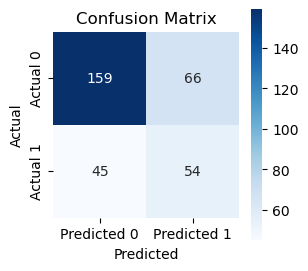


📊 **Initial Model Evaluation (Using Best Threshold):**

🔹 Label 0 (Majority Class)
   📌 Error Rate: 0.2933
   📌 False Positive Rate (FPR): 0.2933
   📌 False Negative Rate (FNR): 0.0000

🔹 Label 1 (Minority Class)
   📌 Error Rate: 0.4545
   📌 False Positive Rate (FPR): 0.0000
   📌 False Negative Rate (FNR): 0.4545
15


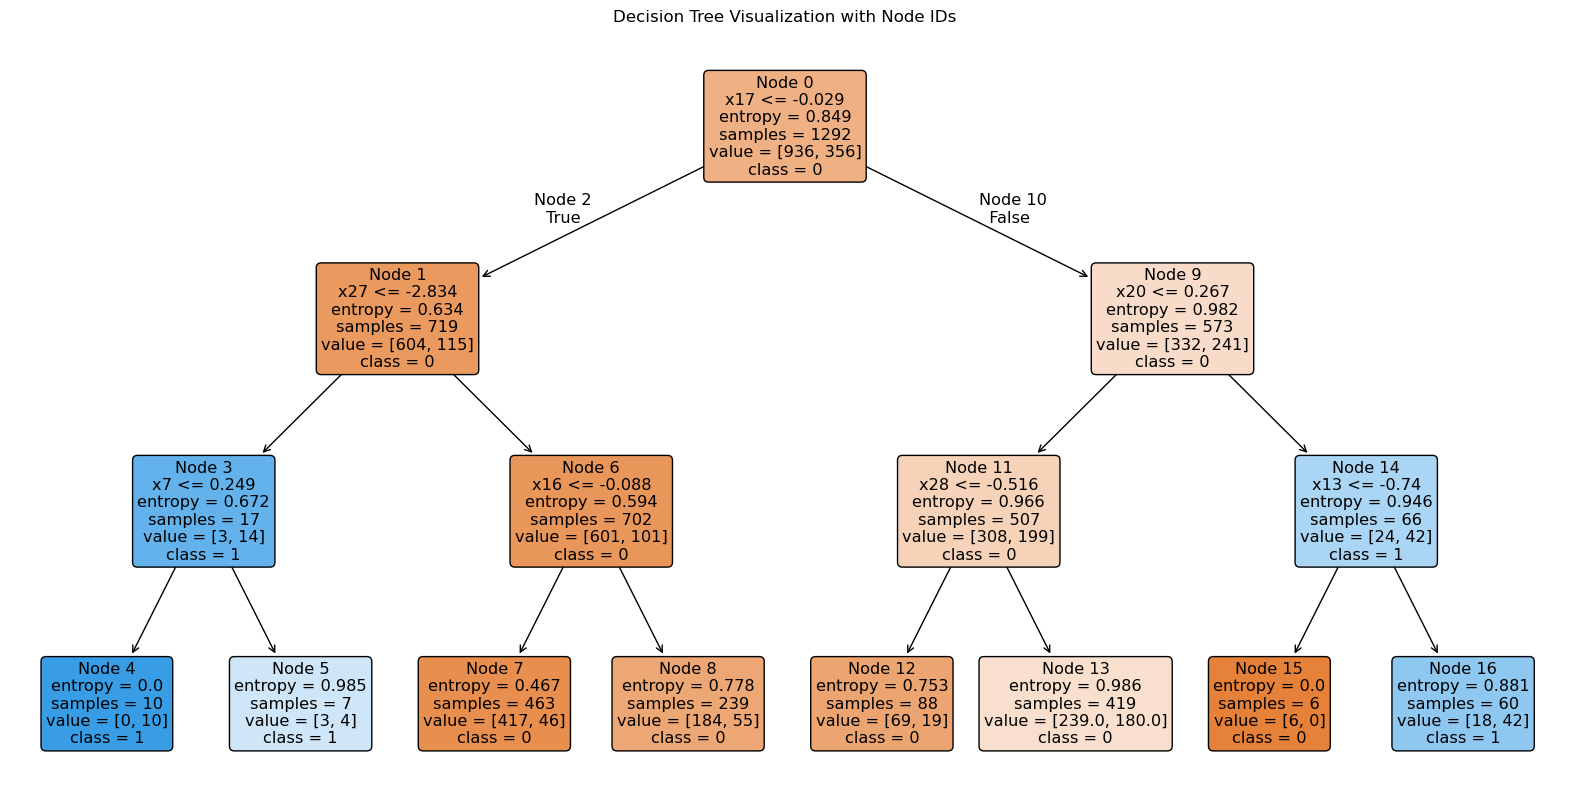

In [2]:
# Example usage
expression_df, labels_df = load_and_prepare_aces_data(base_path)
print(blue_text("Dataset Information:"))
print(f"Number of samples (rows): {expression_df.shape[0]}")
print(f"Number of genes (columns): {expression_df.shape[1]}")
print(blue_text("Labels distribution:"))
print(labels_df.value_counts())

X_train, X_test, y_train, y_test = split_data(expression_df, labels_df)
print("Training Set Size:", X_train.shape)
print("Test Set Size:", X_test.shape)

grid_search = perform_grid_search(X_train, y_train)
best_params = grid_search.best_params_
print(blue_text("Best Parameters:"), best_params)

initial_model = train_best_model(grid_search, X_train, y_train)

best_threshold = find_optimal_threshold(initial_model, X_train, y_train)
print(blue_text("Optimal Threshold from Cross-Validation:"), f"{best_threshold:.2f}")

print("\n" + blue_text("Initial Model Evaluation:"))
evaluate_model(initial_model, X_test, y_test, threshold=best_threshold)


y_proba_initial = initial_model.predict_proba(X_test)[:, 1]
y_pred_initial = (y_proba_initial >= best_threshold).astype(int)

y_test_0_initial = y_test[y_test == 0]
y_test_1_initial = y_test[y_test == 1]

y_pred_0_initial = y_pred_initial[y_test == 0]
y_pred_1_initial = y_pred_initial[y_test == 1]

cm_0_initial = confusion_matrix(y_test_0_initial, y_pred_0_initial, labels=[0, 1])
cm_1_initial = confusion_matrix(y_test_1_initial, y_pred_1_initial, labels=[0, 1])

TN_0_initial, FP_0_initial, FN_0_initial, TP_0_initial = cm_0_initial.ravel() if cm_0_initial.size == 4 else (0, 0, 0, 0)
TN_1_initial, FP_1_initial, FN_1_initial, TP_1_initial = cm_1_initial.ravel() if cm_1_initial.size == 4 else (0, 0, 0, 0)

total_samples_0_initial = TN_0_initial + FP_0_initial + FN_0_initial + TP_0_initial
total_samples_1_initial = TN_1_initial + FP_1_initial + FN_1_initial + TP_1_initial

error_rate_0_initial = (FP_0_initial + FN_0_initial) / total_samples_0_initial if total_samples_0_initial > 0 else 0
fpr_0_initial = FP_0_initial / (FP_0_initial + TN_0_initial) if (FP_0_initial + TN_0_initial) > 0 else 0
fnr_0_initial = FN_0_initial / (FN_0_initial + TP_0_initial) if (FN_0_initial + TP_0_initial) > 0 else 0

error_rate_1_initial = (FP_1_initial + FN_1_initial) / total_samples_1_initial if total_samples_1_initial > 0 else 0
fpr_1_initial = FP_1_initial / (FP_1_initial + TN_1_initial) if (FP_1_initial + TN_1_initial) > 0 else 0
fnr_1_initial = FN_1_initial / (FN_1_initial + TP_1_initial) if (FN_1_initial + TP_1_initial) > 0 else 0

print("\n📊 **Initial Model Evaluation (Using Best Threshold):**\n")

print(f"🔹 Label 0 (Majority Class)")
print(f"   📌 Error Rate: {error_rate_0_initial:.4f}")
print(f"   📌 False Positive Rate (FPR): {fpr_0_initial:.4f}")
print(f"   📌 False Negative Rate (FNR): {fnr_0_initial:.4f}\n")

print(f"🔹 Label 1 (Minority Class)")
print(f"   📌 Error Rate: {error_rate_1_initial:.4f}")
print(f"   📌 False Positive Rate (FPR): {fpr_1_initial:.4f}")
print(f"   📌 False Negative Rate (FNR): {fnr_1_initial:.4f}")


visualize_tree(tree_model=initial_model, feature_names = [f"x{index}" for index in range(X_test.shape[1])])


## Leaf Node Analysis and Valid Range Calculations for features

In [5]:
leaf_classification = classify_leaf_nodes(initial_model, X_train, y_train)

print(blue_text("Leaf Node Classifications:"))
for node, classification in leaf_classification.items():
    print(f"Node {node}: {classification}")

# good_nodes = [node_id for node_id, classification in leaf_classification.items() if classification == 'Good']
# avoid_nodes = get_avoid_nodes_for_good_nodes(good_nodes)

feature_names = X_train.columns.tolist()
good_nodes = [node_id for node_id, classification in leaf_classification.items() if classification == 'Good']
avoid_nodes = {good_node: 6 for good_node in good_nodes}  # Map each good node to avoid node 6feature_names = X_train.columns.tolist()
feature_ranges_for_good_nodes = get_features_and_calculate_ranges(initial_model, X_train, y_train, good_nodes, avoid_nodes, feature_names)

import json

def print_feature_ranges(feature_ranges_for_good_nodes):
    # Convert NumPy int64 keys to standard Python int
    converted_ranges = {int(k): v for k, v in feature_ranges_for_good_nodes.items()}
    formatted_output = json.dumps(converted_ranges, indent=4)
    print(formatted_output)

# Call the function
print_feature_ranges(feature_ranges_for_good_nodes)

valid_feature_ranges = calculate_valid_feature_ranges(feature_ranges_for_good_nodes, prioritized_good_node= 14)

# Extract primary features with valid ranges
primary_features = [feature for feature, ranges in valid_feature_ranges.items() if ranges]

# Print final primary features
print("\n=== Primary Features (with Valid Ranges) ===")
print(primary_features)


# Call the function
# print(blue_text("Generating New Samples for each Good Nodes"))
# generated_samples_by_node = {}
# for good_node in good_nodes:
#     avoid_node = avoid_nodes.get(good_node)
#     target_data = X_train[(initial_model.apply(X_train) == good_node) & (y_train == 1)]
#     num_samples_per_node = len(target_data)

#     target_ranges = feature_ranges_for_good_nodes[good_node]['Good Node']
#     avoid_ranges = feature_ranges_for_good_nodes[good_node]['Avoid Node']
    
#     generated_samples = generate_samples_with_avoidance(target_data, target_ranges, avoid_ranges, num_samples_per_node, RANDOM_STATE)
#     generated_samples_by_node[good_node] = generated_samples

# for node_id, samples_df in generated_samples_by_node.items():
#     print(f"Good Node {node_id}: Generated {len(samples_df)} samples")

# retrained_model = merge_and_retrain_model(
#     original_X_train=X_train,
#     original_y_train=y_train,
#     generated_samples_by_node=generated_samples_by_node,
#     grid_search=grid_search,
#     X_test=X_test,
#     y_test=y_test,
#     threshold=best_threshold,
#     feature_names=[f"x{i}" for i in range(X_train.shape[1])]
# )

Leaf Node Classifications:
Node 3: Good
Node 4: Neutral
Node 6: Bad
Node 7: Bad
Node 10: Bad
Node 11: Neutral
Node 13: Bad
Node 14: Good
{
    "3": {
        "Good Range": {
            "17": [
                -0.6300305648416247,
                -0.10346058851491792
            ],
            "27": [
                -3.9811315227520194,
                -2.901458500580328
            ],
            "7": [
                -1.0679012043138536,
                0.23441610714739053
            ]
        },
        "Avoid Range": {
            "17": [
                -1.937852498208124,
                -0.08883008169495517
            ],
            "27": [
                -2.4351598886791845,
                3.6863675327633274
            ],
            "7": [
                -2.5405237534272334,
                2.6548145567170036
            ]
        }
    },
    "14": {
        "Good Range": {
            "17": [
                -0.015024695915693194,
                1.5008177388689259
 

## Messy Node


In [6]:
# Define the messy node ID
messy_node_id = 11  # Update if needed

# Extract samples belonging to the messy node
messy_node_samples = X_train[initial_model.apply(X_train) == messy_node_id]
messy_node_labels = y_train[initial_model.apply(X_train) == messy_node_id]

# Count the total number of samples
num_messy_samples = len(messy_node_samples)

# Count the number of samples per class
class_distribution = messy_node_labels.value_counts().to_dict()

# Print the details
print(f"Number of data points in Messy Node {messy_node_id}: {num_messy_samples}")
print("Class distribution in Messy Node:")
for class_label, count in class_distribution.items():
    print(f"Class {class_label}: {count} samples")

print()

import numpy as np

# # Define the number of samples to select (10% of the training set)
# num_selected_samples = int(0.1 * len(X_train))

# # Ensure we do not select more samples than available in the messy node
# num_selected_samples = min(num_selected_samples, len(messy_node_samples))

# RANDOM_STATE_MESSY = 7564
# # Randomly select samples from the messy node
# selected_messy_samples = messy_node_samples.sample(n=num_selected_samples, random_state=RANDOM_STATE_MESSY)

# # Print the count of selected samples
# print(f"Selected {num_selected_samples} samples from Messy Node {messy_node_id}.\n")

import itertools

# Generate all unique combinations of these features (1 to 5 at a time)
feature_combinations = []
for r in range(1, len(primary_features) + 1):
    feature_combinations.extend(itertools.combinations(primary_features, r))

print(f"Total number of unique feature combinations: {len(feature_combinations)}\n")

# Print the generated combinations
print(f"Generated {len(feature_combinations)} unique feature combinations:")
for combo in feature_combinations:
    print(combo)

Number of data points in Messy Node 11: 419
Class distribution in Messy Node:
Class 0: 239 samples
Class 1: 180 samples

Total number of unique feature combinations: 7

Generated 7 unique feature combinations:
(17,)
(27,)
(20,)
(17, 27)
(17, 20)
(27, 20)
(17, 27, 20)


In [7]:
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.metrics import confusion_matrix

def evaluate_feature_combinations(selected_messy_samples, X_train, y_train, X_test, y_test, 
                                  feature_combinations, valid_feature_ranges, 
                                  perform_grid_search, train_best_model, best_threshold, 
                                  error_rate_0_initial, error_rate_1_initial,
                                  num_iterations=5, custom_random_seeds=None):
    
    if custom_random_seeds is None:
        custom_random_seeds = [7839, 1236, 4576, 4072, 101112]

    print(f"\nTotal number of unique feature combinations: {len(feature_combinations)}")

    columns = ["# of Features", "Random Seed", "Feature Name", "Label", "Error Rate Difference"]
    results_df = pd.DataFrame(columns=columns)

    for combo in feature_combinations:
        num_features = len(combo)
        print(f"\n🔄 Processing feature combination: {combo}")

        for run_idx, seed in enumerate(custom_random_seeds[:num_iterations]):
            np.random.seed(seed)

            messy_samples = selected_messy_samples.copy()

            print(f"🚀 Run {run_idx + 1} (Seed: {seed})")

            for index in messy_samples.index:
                for feature in combo:
                    if feature in valid_feature_ranges:
                        valid_ranges = valid_feature_ranges[feature]  
                        if isinstance(valid_ranges, list) and all(isinstance(r, tuple) and len(r) == 2 for r in valid_ranges):
                            selected_range = valid_ranges[0]
                            min_value, max_value = selected_range
                            random_value = np.random.uniform(min_value, max_value)
                            messy_samples.at[index, feature] = random_value  

            new_labels = pd.Series(1, index=messy_samples.index, name="label")

            X_train_augmented = pd.concat([X_train, messy_samples], axis=0)
            y_train_augmented = pd.concat([y_train, new_labels], axis=0)

            print(f"✅ Augmented training set created (Size: {X_train_augmented.shape[0]}) for Run {run_idx + 1}")

            grid_search = perform_grid_search(X_train_augmented, y_train_augmented)
            best_params = grid_search.best_params_
            print("Best Parameters:", best_params)

            retrained_model = train_best_model(grid_search, X_train_augmented, y_train_augmented)

            y_proba = retrained_model.predict_proba(X_test)[:, 1]
            y_pred = (y_proba >= best_threshold).astype(int)

            y_test_0 = y_test[y_test == 0]
            y_test_1 = y_test[y_test == 1]

            y_pred_0 = y_pred[y_test == 0]
            y_pred_1 = y_pred[y_test == 1]

            cm_0 = confusion_matrix(y_test_0, y_pred_0, labels=[0, 1])
            cm_1 = confusion_matrix(y_test_1, y_pred_1, labels=[0, 1])

            TN_0, FP_0, FN_0, TP_0 = cm_0.ravel() if cm_0.size == 4 else (0, 0, 0, 0)
            TN_1, FP_1, FN_1, TP_1 = cm_1.ravel() if cm_1.size == 4 else (0, 0, 0, 0)

            total_samples_0 = TN_0 + FP_0 + FN_0 + TP_0
            total_samples_1 = TN_1 + FP_1 + FN_1 + TP_1

            error_rate_0 = (FP_0 + FN_0) / total_samples_0 if total_samples_0 > 0 else 0
            error_rate_1 = (FP_1 + FN_1) / total_samples_1 if total_samples_1 > 0 else 0

            error_rate_diff_0 = error_rate_0_initial - error_rate_0
            error_rate_diff_1 = error_rate_1_initial - error_rate_1

            print(f"📊 Error Rate Differences for Run {run_idx + 1} with Feature Combination {combo}:")
            print(f"   🔹 **Label 0 (Majority Class):** Error Rate Difference: {error_rate_diff_0:.4f}")
            print(f"   🔸 **Label 1 (Minority Class):** Error Rate Difference: {error_rate_diff_1:.4f}")

            results_df = pd.concat([results_df, pd.DataFrame([
                {"# of Features": num_features, "Random Seed": seed, "Feature Name": combo, "Label": 0, "Error Rate Difference": error_rate_diff_0},
                {"# of Features": num_features, "Random Seed": seed, "Feature Name": combo, "Label": 1, "Error Rate Difference": error_rate_diff_1},
            ])], ignore_index=True)

            print(f"✅ Model retrained for Run {run_idx + 1} with feature combination {combo}\n")

        print(f"✅ Finished all runs for feature combination: {combo}\n" + "="*50)
    
    return results_df


RANDOM_STATE_MESSY = 7564
percentages = [0.1, 0.15, 0.2]

results_dict = {}

for percentage in percentages:
    num_selected_samples = int(percentage * len(X_train))
    num_selected_samples = min(num_selected_samples, len(messy_node_samples))
    
    selected_messy_samples = messy_node_samples.sample(n=num_selected_samples, random_state=RANDOM_STATE_MESSY)
    
    print(f"Selected {num_selected_samples} samples ({int(percentage * 100)}%) from Messy Node {messy_node_id}.\n")

    results_df = evaluate_feature_combinations(
        selected_messy_samples, X_train, y_train, X_test, y_test, 
        feature_combinations, valid_feature_ranges, 
        perform_grid_search, train_best_model, best_threshold, 
        error_rate_0_initial, error_rate_1_initial,
        num_iterations=5, custom_random_seeds=[7839, 1236, 4576, 4072, 101112]
    )

    results_dict[f"{int(percentage * 100)}%"] = results_df  # Store separately

Selected 129 samples (10%) from Messy Node 11.


Total number of unique feature combinations: 7

🔄 Processing feature combination: (17,)
🚀 Run 1 (Seed: 7839)
✅ Augmented training set created (Size: 1421) for Run 1
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
📊 Error Rate Differences for Run 1 with Feature Combination (17,):
   🔹 **Label 0 (Majority Class):** Error Rate Difference: -0.0044
   🔸 **Label 1 (Minority Class):** Error Rate Difference: 0.0101
✅ Model retrained for Run 1 with feature combination (17,)

🚀 Run 2 (Seed: 1236)
✅ Augmented training set created (Size: 1421) for Run 2
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}
📊 Error Rate Differences for Run 2 with Feature Combination (17,):
   🔹 **Label 0 (Majority Class):** Error Rate Difference: 0.0178
   🔸 **Label 1 (Minority Class):** Error Rate Difference: -0.0101
✅ Model retrained for Run 2 with feature combi

In [8]:
for key, df in results_dict.items():
    print(f"\n📊 Results for {key} sample size:\n")
    print(df.head(10))  # Display the first few rows of each result dataframe


📊 Results for 10% sample size:

  # of Features Random Seed Feature Name Label  Error Rate Difference
0             1        7839        (17,)     0              -0.004444
1             1        7839        (17,)     1               0.010101
2             1        1236        (17,)     0               0.017778
3             1        1236        (17,)     1              -0.010101
4             1        4576        (17,)     0              -0.013333
5             1        4576        (17,)     1               0.010101
6             1        4072        (17,)     0              -0.004444
7             1        4072        (17,)     1               0.010101
8             1      101112        (17,)     0              -0.013333
9             1      101112        (17,)     1               0.010101

📊 Results for 15% sample size:

  # of Features Random Seed Feature Name Label  Error Rate Difference
0             1        7839        (17,)     0              -0.013333
1             1        7

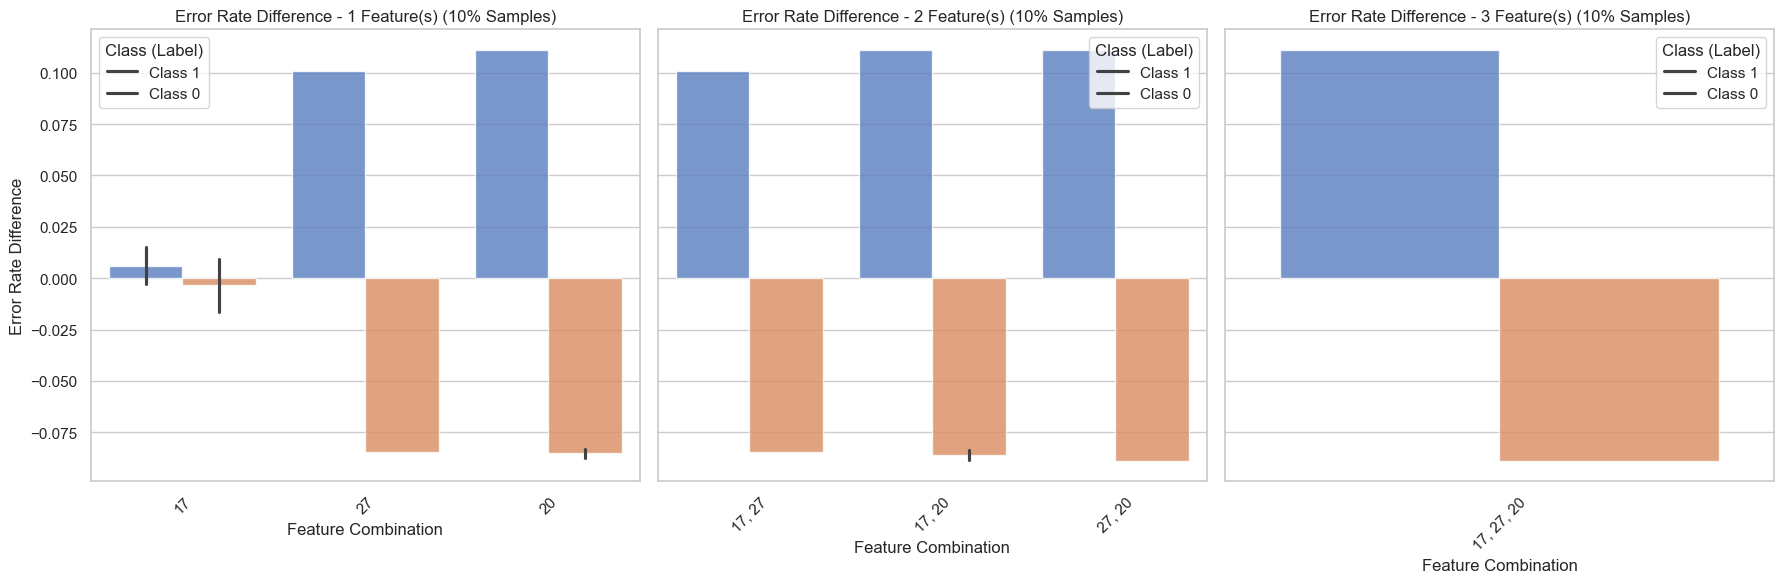

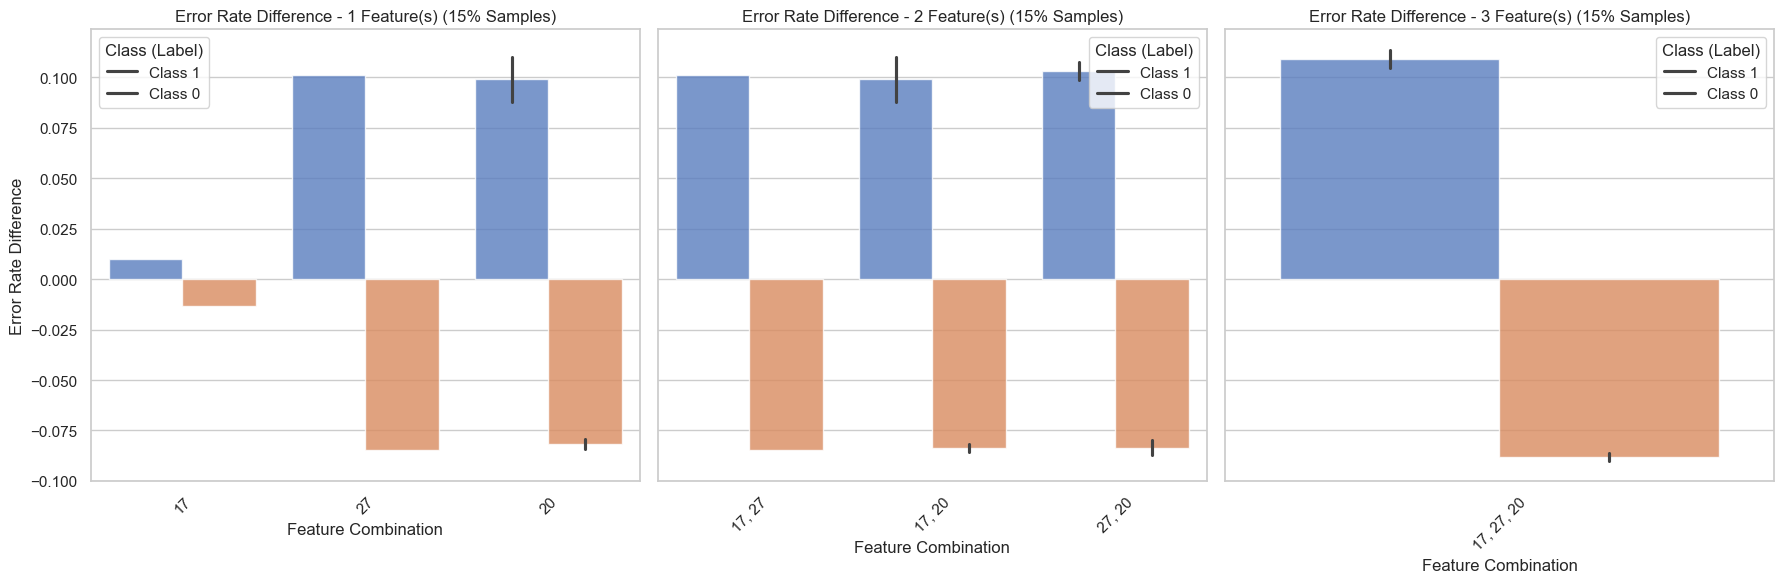

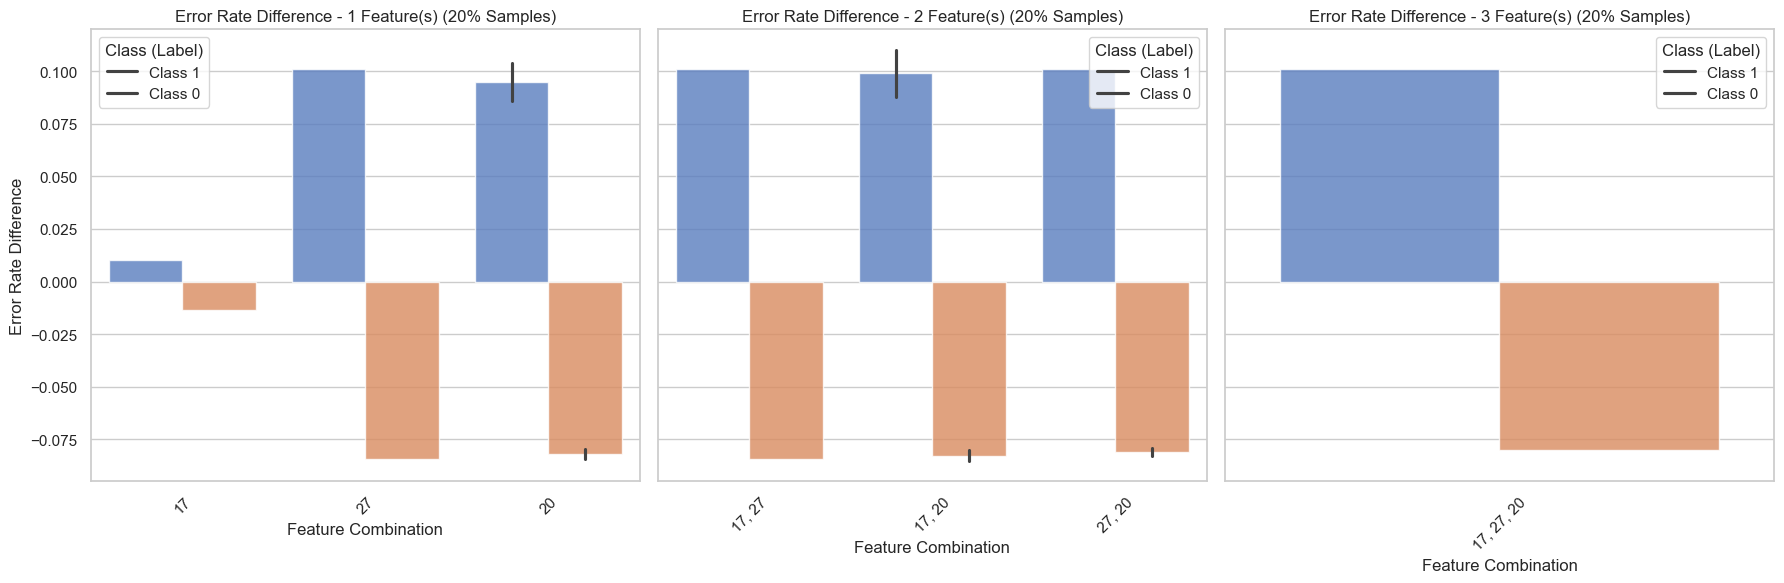

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_error_rate_differences(results_df, title_suffix=""):
    sns.set_theme(style="whitegrid")

    results_df = results_df.copy()
    results_df["Feature Name"] = results_df["Feature Name"].apply(lambda x: ", ".join(map(str, x)))  # Convert tuple to string
    
    unique_features = sorted(results_df["# of Features"].unique())
    num_plots = len(unique_features)

    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 6), sharey=True)

    if num_plots == 1:
        axes = [axes]  

    for i, num_features in enumerate(unique_features):
        filtered_df = results_df[results_df["# of Features"] == num_features]

        sns.barplot(
            data=filtered_df, x="Feature Name", y="Error Rate Difference", hue="Label",
            palette="muted", alpha=0.8, errorbar="sd", ax=axes[i],
            hue_order=[1, 0]  
        )

        axes[i].set_title(f"Error Rate Difference - {num_features} Feature(s) {title_suffix}")
        axes[i].set_xlabel("Feature Combination")
        axes[i].set_ylabel("Error Rate Difference")
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].legend(title="Class (Label)", labels=["Class 1", "Class 0"])  

    plt.tight_layout()
    plt.show()

# Call function for different dataframes

for key, df in results_dict.items():
    plot_error_rate_differences(df, title_suffix=f"({key} Samples)")

Here is the updated code without the comments:



Total samples in messy node 11: 419
Augmented Training Set Size: 1711 (was 1292)
Test Accuracy: 0.66
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74       225
           1       0.45      0.56      0.50        99

    accuracy                           0.66       324
   macro avg       0.62      0.63      0.62       324
weighted avg       0.68      0.66      0.67       324



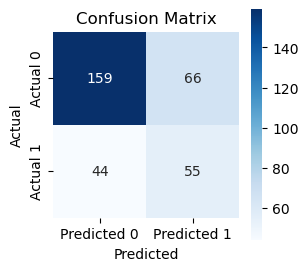

15


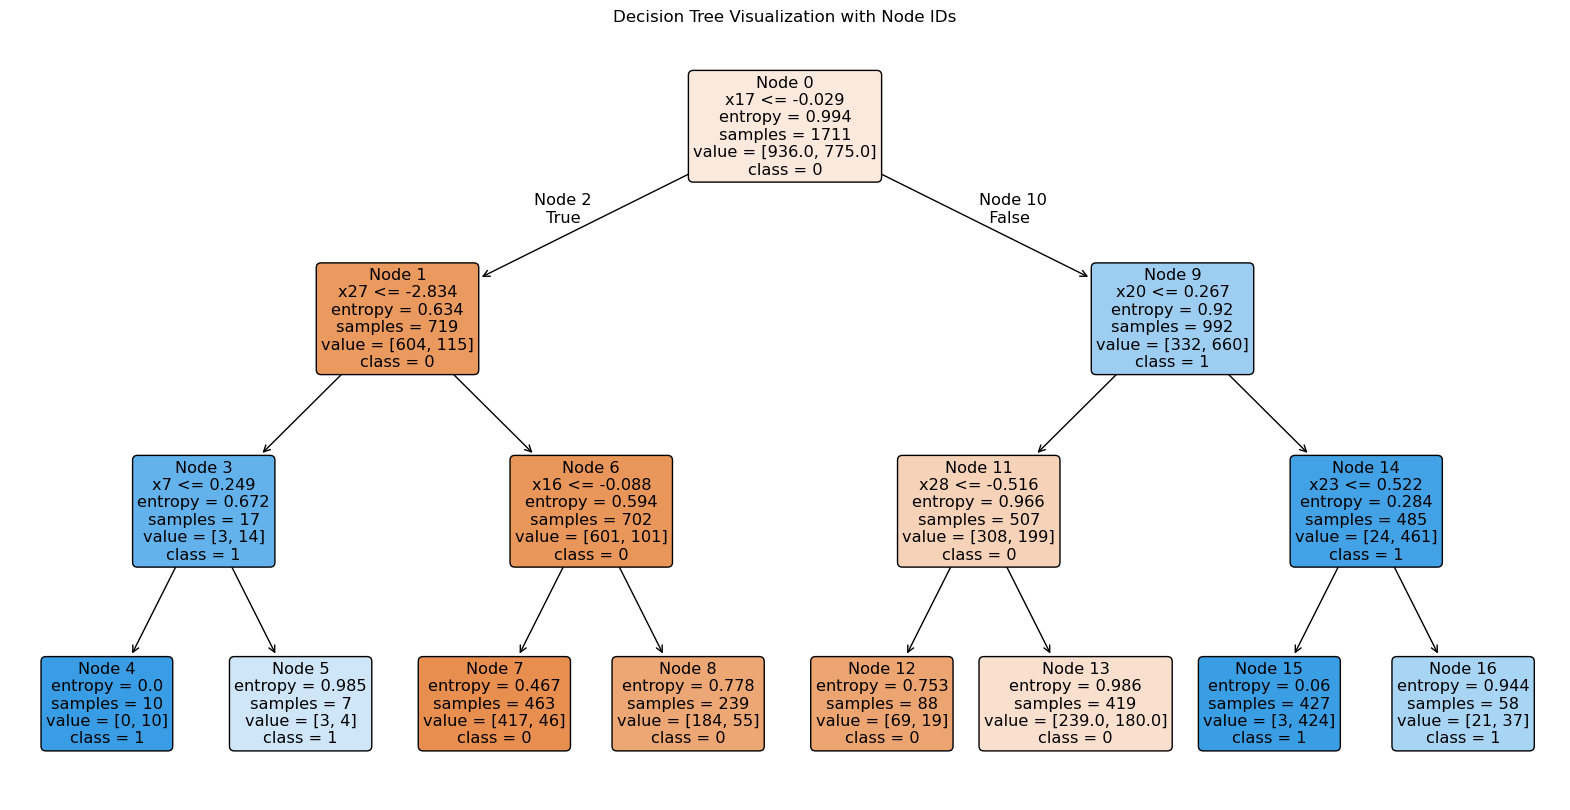

In [ ]:
messy_node_id = 11
messy_node_samples = X_train[(initial_model.apply(X_train) == messy_node_id)]
num_messy_samples = len(messy_node_samples)

print(f"Total samples in messy node {messy_node_id}: {num_messy_samples}")

important_features = [17,20,13, 27, 7]

def swap_features_with_good_nodes(messy_samples, good_nodes_ranges, features_to_swap):
    new_samples = messy_samples.copy()
    for feature in features_to_swap:
        min_value, max_value = good_nodes_ranges.get(feature, (None, None))
        if min_value is not None and max_value is not None:
            new_samples[feature] = np.random.uniform(min_value, max_value, size=len(new_samples))
    return new_samples

new_messy_samples = swap_features_with_good_nodes(messy_node_samples, feature_ranges_for_good_nodes[good_nodes[0]]['Good Node'], important_features)

new_messy_samples['label'] = 1

X_train_augmented = pd.concat([X_train, new_messy_samples.drop(columns=['label'])], axis=0)
y_train_augmented = pd.concat([y_train, new_messy_samples['label']], axis=0)

print(f"Augmented Training Set Size: {X_train_augmented.shape[0]} (was {X_train.shape[0]})")
# Step 7: Retrain the Decision Tree on Augmented Data
retrained_model = train_best_model(grid_search, X_train_augmented, y_train_augmented)

# Step 8: Evaluate the Retrained Model
evaluate_model(retrained_model, X_test, y_test, threshold=best_threshold)

# Step 9: Visualize the Updated Decision Tree
visualize_tree(retrained_model, feature_names=[f"x{i}" for i in range(X_train.shape[1])])


In [10]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import itertools

# Define constants
RANDOM_STATE = 42
FEATURES_TO_SWAP = [17, 20, 13, 27, 7]

# Helper function to swap features
def swap_features(samples, features_to_swap, good_node_ranges, avoid_node_ranges, random_seed):
    np.random.seed(random_seed)
    modified_samples = samples.copy()
    for feature in features_to_swap:
        if feature in good_node_ranges:
            # Get the valid range from the Good node
            good_min, good_max = good_node_ranges[feature]
            
            # Get the avoid range from the Avoid node (if it exists)
            avoid_min, avoid_max = avoid_node_ranges.get(feature, (None, None))
            
            # Generate new values within the Good node range, avoiding the Avoid node range
            if avoid_min is not None and avoid_max is not None:
                # Split the Good node range into two parts: before and after the Avoid range
                if good_min < avoid_min:
                    # Generate values in the lower part of the Good range
                    lower_values = np.random.uniform(good_min, avoid_min, size=len(modified_samples))
                else:
                    lower_values = np.array([])
                
                if good_max > avoid_max:
                    # Generate values in the upper part of the Good range
                    upper_values = np.random.uniform(avoid_max, good_max, size=len(modified_samples))
                else:
                    upper_values = np.array([])
                
                # Combine the lower and upper values
                if len(lower_values) > 0 and len(upper_values) > 0:
                    new_values = np.where(np.random.rand(len(modified_samples)) < 0.5, lower_values, upper_values)
                elif len(lower_values) > 0:
                    new_values = lower_values
                elif len(upper_values) > 0:
                    new_values = upper_values
                else:
                    # If the entire Good range is within the Avoid range, skip this feature
                    continue
            else:
                # If there is no Avoid range, generate values within the entire Good range
                new_values = np.random.uniform(good_min, good_max, size=len(modified_samples))
            
            # Update the feature values
            modified_samples[feature] = new_values
    
    return modified_samples


# Function to evaluate feature combinations (focusing on class 1)
def evaluate_feature_combinations(messy_samples, good_node_ranges, avoid_node_ranges, features_to_swap, random_seed, initial_model, X_train, y_train, X_test, y_test, best_threshold):
    results = []
    
    # Iterate over the number of features to swap (1 to 5)
    for r in range(1, len(features_to_swap) + 1):
        # Generate all combinations of size r
        for combo in itertools.combinations(features_to_swap, r):
            # Swap features in the messy node samples
            modified_samples = swap_features(messy_samples, combo, good_node_ranges, avoid_node_ranges, random_seed)
            modified_samples['label'] = 1  # Assign the minority class label
            
            # Augment the training data
            X_train_augmented = pd.concat([X_train, modified_samples.drop(columns=['label'])], axis=0)
            y_train_augmented = pd.concat([y_train, modified_samples['label']], axis=0)
            
            # Retrain the model
            retrained_model = train_best_model(grid_search, X_train_augmented, y_train_augmented)
            
            # Evaluate the model
            y_proba = retrained_model.predict_proba(X_test)[:, 1]
            y_pred = (y_proba >= best_threshold).astype(int)
            
            # Compute metrics for class 1 only
            accuracy = accuracy_score(y_test, y_pred)  # Accuracy is the same for all classes
            precision = precision_score(y_test, y_pred, pos_label=1)  # Precision for class 1
            recall = recall_score(y_test, y_pred, pos_label=1)  # Recall for class 1
            f1 = f1_score(y_test, y_pred, pos_label=1)  # F1 score for class 1
            
            # Save the results
            results.append({
                'num_features_swapped': r,
                'features_swapped': combo,
                'random_seed': random_seed,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            })
    
    return pd.DataFrame(results)

In [11]:
# Define messy node samples and good node ranges
messy_node_id = 11
messy_node_samples = X_train[(initial_model.apply(X_train) == messy_node_id)]
good_node_ranges = feature_ranges_for_good_nodes[good_nodes[0]]['Good Node']
avoid_node_ranges = feature_ranges_for_good_nodes[good_nodes[0]]['Avoid Node']


print(good_node_ranges)

# Evaluate feature combinations
results_df = evaluate_feature_combinations(
        messy_samples=messy_node_samples,
        good_node_ranges=good_node_ranges,
        avoid_node_ranges=avoid_node_ranges,
        features_to_swap=FEATURES_TO_SWAP,
        random_seed=RANDOM_STATE,
        initial_model=initial_model,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        best_threshold=best_threshold
    )


# Save results to a spreadsheet
results_df.to_csv('feature_swap_results.csv', index=False)
print("Results saved to 'feature_swap_results.csv'")

{17: (-0.015024695915693194, 1.5008177388689259), 20: (0.2693023348517156, 1.1609997617752696), 13: (-0.7375557569336142, 2.7820454420116563)}
Results saved to 'feature_swap_results.csv'


In [4]:
# Import necessary libraries
import itertools
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from openpyxl.styles import Font, Border, Side, PatternFill, Alignment
from openpyxl.utils import get_column_letter

# Define the messy node and features to swap
FEATURES_TO_SWAP = [17, 20, 13, 27, 7]

# Compute Class 1 Metrics using the Initial Model (before swapping)
y_proba_initial = initial_model.predict_proba(X_test)[:, 1]
y_pred_initial = (y_proba_initial >= best_threshold).astype(int)

default_class_1_results = {
    'num_features_swapped': 0,  # Default row with 0 swaps
    'features_swapped': "None",
    'class_1_accuracy': round(accuracy_score(y_test[y_test == 1], y_pred_initial[y_test == 1]), 2),
    'class_1_precision': round(precision_score(y_test, y_pred_initial, pos_label=1), 2),
    'class_1_recall': round(recall_score(y_test, y_pred_initial, pos_label=1), 2),
    'class_1_f1_score': round(f1_score(y_test, y_pred_initial, pos_label=1), 2)
}

# Convert to DataFrame
default_results_df = pd.DataFrame([default_class_1_results])

# Define the messy node ID (update based on your tree structure)
messy_node_id = 11  

# Extract samples that belong to the messy node from the training set
messy_node_samples = X_train[(initial_model.apply(X_train) == messy_node_id)]

# Function to swap features in messy node using good node feature ranges
def swap_features(samples, features_to_swap, good_node_ranges, avoid_node_ranges):
    modified_samples = samples.copy()
    
    for feature in features_to_swap:
        if feature in good_node_ranges:
            good_min, good_max = good_node_ranges[feature]
            avoid_min, avoid_max = avoid_node_ranges.get(feature, (None, None))

            if avoid_min is not None and avoid_max is not None:
                # Generate values avoiding the avoid node range
                lower_values = np.random.uniform(good_min, avoid_min, len(samples)) if good_min < avoid_min else np.array([])
                upper_values = np.random.uniform(avoid_max, good_max, len(samples)) if good_max > avoid_max else np.array([])
                
                if len(lower_values) > 0 and len(upper_values) > 0:
                    new_values = np.where(np.random.rand(len(samples)) < 0.5, lower_values, upper_values)
                elif len(lower_values) > 0:
                    new_values = lower_values
                elif len(upper_values) > 0:
                    new_values = upper_values
                else:
                    continue
            else:
                new_values = np.random.uniform(good_min, good_max, len(samples))

            modified_samples[feature] = new_values
    
    return modified_samples

# Evaluate different feature swap combinations
def evaluate_feature_combinations(messy_samples, good_node_ranges, avoid_node_ranges, features_to_swap, initial_model, X_train, y_train, X_test, y_test, best_threshold):
    results = []
    
    for r in range(1, len(features_to_swap) + 1):
        for combo in itertools.combinations(features_to_swap, r):
            modified_samples = swap_features(messy_samples, combo, good_node_ranges, avoid_node_ranges)
            modified_samples['label'] = 1  
            
            # Augment the dataset
            X_train_aug = pd.concat([X_train, modified_samples.drop(columns=['label'])], axis=0)
            y_train_aug = pd.concat([y_train, modified_samples['label']], axis=0)

            # Retrain the model
            retrained_model = train_best_model(grid_search, X_train_aug, y_train_aug)
            y_pred = (retrained_model.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)

            # Compute performance metrics for class 1 only
            results.append({
                'num_features_swapped': r,
                'features_swapped': combo,
                'class_1_accuracy': round(accuracy_score(y_test[y_test == 1], y_pred[y_test == 1]), 2),
                'class_1_precision': round(precision_score(y_test, y_pred, pos_label=1), 2),
                'class_1_recall': round(recall_score(y_test, y_pred, pos_label=1), 2),
                'class_1_f1_score': round(f1_score(y_test, y_pred, pos_label=1), 2)
            })
    
    return pd.DataFrame(results)

# Format Excel sheet
def format_excel_sheet(sheet):
    header_font = Font(bold=True, color="FFFFFF")
    header_fill = PatternFill(start_color="4F81BD", end_color="4F81BD", fill_type="solid")
    header_alignment = Alignment(horizontal="center", vertical="center")
    thin_border = Border(left=Side(style='thin'), right=Side(style='thin'), top=Side(style='thin'), bottom=Side(style='thin'))
    
    for cell in sheet[1]:
        cell.font = header_font
        cell.fill = header_fill
        cell.alignment = header_alignment
        cell.border = thin_border

    for col in sheet.columns:
        max_length = max(len(str(cell.value)) for cell in col if cell.value)
        sheet.column_dimensions[get_column_letter(col[0].column)].width = (max_length + 2) * 1.2

    sheet.freeze_panes = "A2"
    for row in sheet.iter_rows(min_row=2):
        for cell in row:
            cell.border = thin_border

# Run the experiment and aggregate results
print("Running feature swap experiment...")
results_df = evaluate_feature_combinations(
    messy_samples=messy_node_samples,
    good_node_ranges=feature_ranges_for_good_nodes[good_nodes[0]]['Good Node'],
    avoid_node_ranges=feature_ranges_for_good_nodes[good_nodes[0]]['Avoid Node'],
    features_to_swap=FEATURES_TO_SWAP,
    initial_model=initial_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    best_threshold=best_threshold
)

# Preserve the original order (DO NOT SORT)
aggregated_results = results_df.groupby(['num_features_swapped', 'features_swapped'], as_index=False).agg({
    'class_1_accuracy': 'mean',
    'class_1_precision': 'mean',
    'class_1_recall': 'mean',
    'class_1_f1_score': 'mean'
}).round(2)  # Round to 2 decimal places

# Insert default results row at the top
final_results_df = pd.concat([default_results_df, aggregated_results], ignore_index=True)  

# Save results to a single Excel sheet
with pd.ExcelWriter('experiment_results_aggregated.xlsx', engine='openpyxl') as writer:
    final_results_df.to_excel(writer, sheet_name='Results', index=False)  

    # Format the sheet
    format_excel_sheet(writer.sheets['Results'])

print("✅ Results saved to 'experiment_results_aggregated.xlsx' with default class 1 values on top in a single sheet.")

Running feature swap experiment...
✅ Results saved to 'experiment_results_aggregated.xlsx' with default class 1 values on top in a single sheet.


In [1]:
import scipy.io
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree
import shap
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import os
from scipy.special import softmax
from scipy.stats import entropy
from scipy.stats import pearsonr
from xgboost import XGBClassifier

RANDOM_STATE = 42
TEST_SIZE = 0.2
CLASSIFICATION_THRESHOLD = .26
SELECTED_FEATURES = [7, 8, 13, 16, 17, 20, 27, 28, 35]
SHAP_FILE = "shap_values_map.pkl"
base_path = '/Users/asifahmed/Documents/Codes/MyRecourseProject/datasets/ACES_dataset'

# Step 1: Load the dataset
def load_and_prepare_aces_data(base_path):
    expression_data = scipy.io.loadmat(f'{base_path}/ACES_RefinedCommunity_AVG.mat')
    label_data = scipy.io.loadmat(f'{base_path}/ACESLabel.mat')
    expression_matrix = expression_data['data']
    labels = label_data['label'].flatten()
    expression_df = pd.DataFrame(expression_matrix)
    labels_df = pd.Series(labels, name='label')
    return expression_df, labels_df

# Step 2: Split the dataset
def split_data(expression_df, labels_df, test_size=TEST_SIZE, random_state=RANDOM_STATE):
    X_train, X_test, y_train, y_test = train_test_split(expression_df, labels_df, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

# Step 3: Define and train models
def train_models(X_train, y_train):
    models = {
        'SVM': SVC(kernel='linear',probability=True, random_state=RANDOM_STATE),
        'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_STATE),
        'RandomForest': RandomForestClassifier(random_state=RANDOM_STATE),
        'GradientBoosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
        'NeuralNetwork': MLPClassifier(random_state=RANDOM_STATE, max_iter=500)
    }
    trained_models = {}
    
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        trained_models[name] = model
        print(f"{name} trained successfully.")
    
    return trained_models

# Step 4: Compute SHAP values for each model
def compute_shap_values(models, X_train):
    shap_values_map = {}
    
    for name, model in models.items():
        print(f"Computing SHAP values for {name}...")
        if hasattr(model, 'predict_proba'):
            explainer = shap.Explainer(model.predict_proba, X_train)
        else:
            explainer = shap.Explainer(model, X_train)
        
        shap_values = explainer(X_train)
        shap_values_map[name] = shap_values
        print(f"SHAP values computed for {name}.")
    
    return shap_values_map

def load_or_compute_shap_values(trained_models, X_train, shap_values_file="shap_values_map.pkl"):
    if os.path.exists(shap_values_file):
        print(f"Loading SHAP values from {shap_values_file}...")
        with open(shap_values_file, "rb") as file:
            shap_values_map = pickle.load(file)
        print("SHAP values successfully loaded.")
    else:
        print("SHAP values file not found. Computing SHAP values...")
        shap_values_map = compute_shap_values(trained_models, X_train)
        with open(shap_values_file, "wb") as file:
            pickle.dump(shap_values_map, file)
        print(f"SHAP values computed and saved to {shap_values_file}.")
    
    return shap_values_map

def filter_instances_by_cosine_majority_voting(shap_values_map, selected_features=None, pairwise_threshold=0.5):
    model_names = list(shap_values_map.keys())
    n_instances = len(shap_values_map[model_names[0]].values)
    
    # Default to all features if selected_features is None
    all_features = list(range(shap_values_map[model_names[0]].values.shape[1]))
    selected_features = selected_features if selected_features is not None else all_features
    
    retained_indices = []

    for i in range(n_instances):
        shap_vectors = np.array([
            shap_values_map[model].values[i, selected_features].mean(axis=1) for model in model_names
        ])

        shap_vectors = shap_vectors / np.linalg.norm(shap_vectors, axis=1, keepdims=True)

        similarity_matrix = cosine_similarity(shap_vectors)
        # print(f"Instance {i}: Cosine Similarity Matrix =\n{similarity_matrix}")

        pairwise_similarities = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]
        # print(f"Instance {i}: Pairwise Cosine Values: {np.round(pairwise_similarities, 3).tolist()}")

        pairwise_above_threshold = np.sum(pairwise_similarities > pairwise_threshold)
        total_pairs = len(pairwise_similarities)
        majority_threshold = total_pairs // 2

        if pairwise_above_threshold >= majority_threshold:
            retained_indices.append(i)

        # print(f"Instance {i}: Pairwise Above Threshold = {pairwise_above_threshold}, Retained = {pairwise_above_threshold >= majority_threshold}")

    # print(f"Total retained instances: {len(retained_indices)}")
    return retained_indices

def filter_instances_by_cosine_average_similarity(shap_values_map, selected_features=None, average_similarity_threshold=0.1):
    model_names = list(shap_values_map.keys())
    n_instances = len(shap_values_map[model_names[0]].values)
    
    # Default to all features if selected_features is None
    all_features = list(range(shap_values_map[model_names[0]].values.shape[1]))
    selected_features = selected_features if selected_features is not None else all_features
    
    retained_indices = []

    for i in range(n_instances):
        shap_vectors = np.array([
            shap_values_map[model].values[i, selected_features].mean(axis=1) for model in model_names
        ])

        shap_vectors = shap_vectors / np.linalg.norm(shap_vectors, axis=1, keepdims=True)

        similarity_matrix = cosine_similarity(shap_vectors)
        print(f"Instance {i}: Cosine Similarity Matrix =\n{similarity_matrix}")

        pairwise_similarities = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]

        average_similarity = np.mean(pairwise_similarities)

        retained = average_similarity > average_similarity_threshold
        print(f"Instance {i}: Average Similarity = {average_similarity:.4f}, Retained = {retained}")

        if retained:
            retained_indices.append(i)

    print(f"Total retained instances: {len(retained_indices)}")
    return retained_indices


def filter_instances_by_pearson_correlation_majority_voting(shap_values_map, selected_features=None, correlation_threshold=0):
    model_names = list(shap_values_map.keys())
    n_instances = len(shap_values_map[model_names[0]].values)
    
    # Default to all features if selected_features is None
    all_features = list(range(shap_values_map[model_names[0]].values.shape[1]))
    selected_features = selected_features if selected_features is not None else all_features
    
    retained_indices = []

    for i in range(n_instances):
        shap_vectors = np.array([
            shap_values_map[model].values[i, selected_features].mean(axis=1) for model in model_names
        ])

        # Compute pairwise Pearson correlations for SHAP vectors
        pairwise_correlations = []
        for j in range(len(shap_vectors)):
            for k in range(j + 1, len(shap_vectors)):
                corr, _ = pearsonr(shap_vectors[j], shap_vectors[k])
                pairwise_correlations.append(corr)

        # Count the number of pairwise correlations exceeding the threshold
        pairwise_above_threshold = np.sum(np.array(pairwise_correlations) >= correlation_threshold)

        # Determine if the instance should be retained based on majority voting
        total_pairs = len(pairwise_correlations)
        majority_threshold = total_pairs // 2
        retained = pairwise_above_threshold >= majority_threshold

        # Print details for debugging
        # print(f"Instance {i}: Pairwise Pearson Correlations: {np.round(pairwise_correlations, 3).tolist()}")
        # print(f"Instance {i}: Pairwise Above Threshold = {pairwise_above_threshold}, Retained = {retained}")

        # Retain the instance if the majority of correlations exceed the threshold
        if retained:
            retained_indices.append(i)

    # print(f"Total retained instances based on Pearson Correlation Majority Voting: {len(retained_indices)}")
    return retained_indices

def filter_instances_by_kl_divergence(shap_values_map, selected_features=None, kl_threshold=0.5):
    model_names = list(shap_values_map.keys())
    n_instances = len(shap_values_map[model_names[0]].values)
    
    all_features = list(range(shap_values_map[model_names[0]].values.shape[1]))
    selected_features = selected_features if selected_features is not None else all_features
    
    retained_indices = []

    for i in range(n_instances):
        shap_vectors = np.array([
            shap_values_map[model].values[i, selected_features] for model in model_names
        ])
        
        # Convert SHAP vectors to probability distributions using softmax
        shap_distributions = np.array([softmax(vector) for vector in shap_vectors])
        
        # Compute pairwise KL divergence
        pairwise_kl_divergences = []
        for j in range(len(shap_distributions)):
            for k in range(j + 1, len(shap_distributions)):
                kl_div = entropy(shap_distributions[j], shap_distributions[k])
                pairwise_kl_divergences.append(kl_div)
        
        # Compute the average KL divergence for the instance
        avg_kl_divergence = np.mean(pairwise_kl_divergences)

        # Determine retention status based on the KL divergence threshold
        retained = avg_kl_divergence <= kl_threshold
        print(f"Instance {i}: Average KL Divergence = {avg_kl_divergence:.4f}, Retained = {retained}")

        if retained:
            retained_indices.append(i)

    print(f"Total retained instances based on KL Divergence: {len(retained_indices)}")
    return retained_indices

def randomly_remove_data(X, n=500, random_state=RANDOM_STATE):
    np.random.seed(random_state)

    all_indices = X.index.tolist()

    indices_to_remove = np.random.choice(all_indices, size=n, replace=False)

    retained_indices = [idx for idx in all_indices if idx not in indices_to_remove]
    return retained_indices

def train_decision_tree_on_retained_instances(X_train, y_train, retained_indices):
    # Filter the training data based on retained indices
    X_train_retained = X_train.iloc[retained_indices]
    y_train_retained = y_train.iloc[retained_indices]

    print(f"Training data size after filtering: {X_train_retained.shape}, {y_train_retained.shape}")
    
    # Define hyperparameter grid
    param_grid = {
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 3, 5],
        'criterion': ['gini', 'entropy']
    }
    
    # Initialize DecisionTreeClassifier
    dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

    # Perform grid search
    grid_search = GridSearchCV(
        estimator=dt,
        param_grid=param_grid,
        scoring='accuracy',
        cv=10,
        n_jobs=-1
    )
    # print("Performing grid search...")
    grid_search.fit(X_train_retained, y_train_retained)

    # Retrieve the best model and parameters
    best_model = grid_search.best_estimator_
    print("Best Parameters for Decision Tree:", grid_search.best_params_)
    
    # Train the best model on the retained training data
    best_model.fit(X_train_retained, y_train_retained)
    print("Decision Tree model trained on retained instances.")
    
    return best_model

def train_model_with_grid_search(X_train, y_train, model, param_grid, scoring='accuracy', cv=10):
    print(f"Training data size: {X_train.shape}, {y_train.shape}")
    
    # Perform grid search
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=-1
    )
    print("Performing grid search...")
    grid_search.fit(X_train, y_train)

    # Retrieve the best model and parameters
    best_model = grid_search.best_estimator_
    print("Best Parameters:", grid_search.best_params_)
    
    # Train the best model on the training data
    best_model.fit(X_train, y_train)
    print(f"{model.__class__.__name__} model trained on the provided dataset.")
    
    return best_model

/opt/anaconda3/envs/research_new/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Experminet 1

AUC for the three models (svm, xgboost, random forest) by removing 0, 50, 100, 200, 300, 400 and 500 training instances using the cosine similarity.

In [13]:
expression_df, labels_df = load_and_prepare_aces_data(base_path)

X_train, X_test, y_train, y_test = split_data(expression_df, labels_df)
print("Training Set Size:", X_train.shape)
print("Test Set Size:", X_test.shape)

trained_models = train_models(X_train, y_train)

shap_values_map = load_or_compute_shap_values(trained_models, X_train, shap_values_file=SHAP_FILE)

# Thresholds to remove instances
thresholds = [-0.2, -0.14, -0.1, -0.06, 0]

# Models and their parameter grids
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=RANDOM_STATE),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [5, 10],
            'min_samples_split': [2, 5]
        }
    },
    'SVM': {
        'model': SVC(probability=True, random_state=RANDOM_STATE),
        'param_grid': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(
            random_state=RANDOM_STATE, 
            eval_metric='logloss', 
            disable_default_eval_metric=True
        ),
        'param_grid': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    }
}

# Initialize results list
results_list = []

# Step 1: Evaluate models without removing instances
for model_name, model_info in models.items():
    print(f"Training {model_name} without removing instances...")
    model = model_info['model']
    param_grid = model_info['param_grid']

    # Perform Grid Search
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=10,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # Save the best model
    best_model = grid_search.best_estimator_

    # Compute Train AUC
    y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
    train_auc = roc_auc_score(y_train, y_train_pred_proba)

    # Compute Test AUC
    y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, y_test_pred_proba)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)

    # Append results to list
    results_list.append({
        "Threshold": "No Removal",
        "Model": model_name,
        "Train AUC": train_auc,
        "Test AUC": test_auc,
        "Removed Instances": 0,
        "FPR": fpr.tolist(),
        "TPR": tpr.tolist()
    })

# Step 2: Evaluate models with filtered instances
for threshold in thresholds:
    print(f"Processing Threshold: {threshold}")
    
    # Filter instances using the threshold
    retained_indices = filter_instances_by_cosine_majority_voting(
        shap_values_map, selected_features=SELECTED_FEATURES, pairwise_threshold=threshold
    )
    
    print(f"Number of retained instances: {len(retained_indices)}")
    
    # Filter X_train and y_train based on retained indices
    X_train_filtered = X_train.iloc[retained_indices]
    y_train_filtered = y_train.iloc[retained_indices]
    removed_instances = len(X_train) - len(X_train_filtered)
    print(f"Number of removed instances: {removed_instances}")
    
    # Train models and compute AUC
    for model_name, model_info in models.items():
        print(f"Training {model_name} with threshold {threshold}...")
        model = model_info['model']
        param_grid = model_info['param_grid']

        # Perform Grid Search
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring='roc_auc',
            cv=10,
            n_jobs=-1
        )
        grid_search.fit(X_train_filtered, y_train_filtered)

        # Save the best model
        best_model = grid_search.best_estimator_

        # Compute Train AUC
        y_train_pred_proba = best_model.predict_proba(X_train_filtered)[:, 1]
        train_auc = roc_auc_score(y_train_filtered, y_train_pred_proba)

        # Compute Test AUC
        y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
        y_test_pred_fixed = (y_test_pred_proba >= CLASSIFICATION_THRESHOLD).astype(int)
        test_auc = roc_auc_score(y_test, y_test_pred_proba)

        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)

        # Append results to list
        results_list.append({
            "Threshold": threshold,
            "Model": model_name,
            "Train AUC": train_auc,
            "Test AUC": test_auc,
            "Removed Instances": removed_instances,
            "FPR": fpr.tolist(),
            "TPR": tpr.tolist()
        })

# Convert results list to DataFrame
results_df = pd.DataFrame(results_list)

print(results_df)

Training Set Size: (1292, 37)
Test Set Size: (324, 37)
Training SVM...
SVM trained successfully.
Training DecisionTree...
DecisionTree trained successfully.
Training RandomForest...
RandomForest trained successfully.
Training GradientBoosting...
GradientBoosting trained successfully.
Training NeuralNetwork...


/opt/anaconda3/envs/research_new/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


NeuralNetwork trained successfully.
Loading SHAP values from shap_values_map.pkl...
SHAP values successfully loaded.
Training RandomForest without removing instances...
Training SVM without removing instances...
Training XGBoost without removing instances...
Processing Threshold: -0.2
Number of retained instances: 1249
Number of removed instances: 43
Training RandomForest with threshold -0.2...
Training SVM with threshold -0.2...
Training XGBoost with threshold -0.2...
Processing Threshold: -0.14
Number of retained instances: 1175
Number of removed instances: 117
Training RandomForest with threshold -0.14...
Training SVM with threshold -0.14...
Training XGBoost with threshold -0.14...
Processing Threshold: -0.1
Number of retained instances: 1096
Number of removed instances: 196
Training RandomForest with threshold -0.1...
Training SVM with threshold -0.1...
Training XGBoost with threshold -0.1...
Processing Threshold: -0.06
Number of retained instances: 982
Number of removed instances:

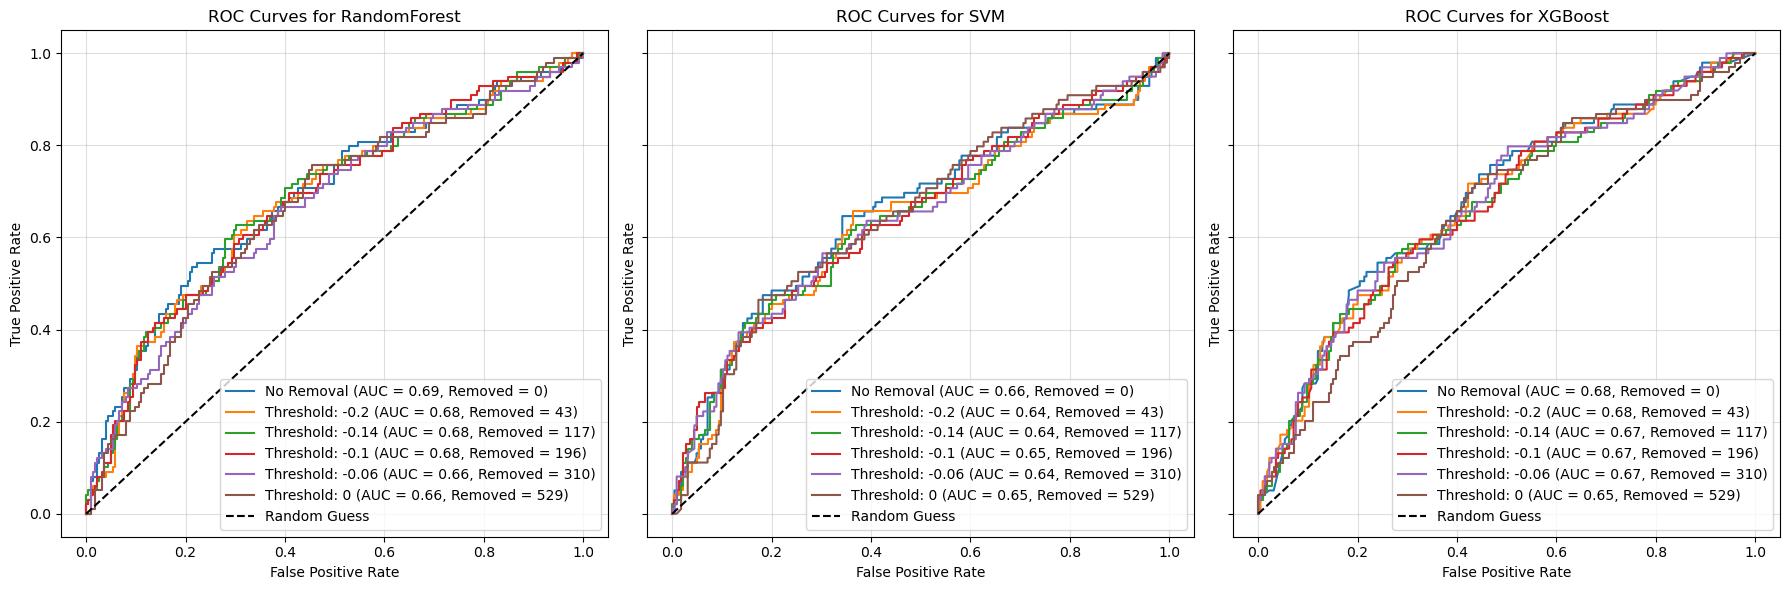

In [14]:
import matplotlib.pyplot as plt
import ast  # For safely evaluating FPR and TPR lists stored as strings

# Ensure FPR and TPR columns are evaluated as Python lists
results_df['FPR'] = results_df['FPR'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
results_df['TPR'] = results_df['TPR'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# List of unique models
models = results_df['Model'].unique()

# Set up the figure with subplots
fig, axes = plt.subplots(1, len(models), figsize=(18, 6), sharey=True)

# Plot ROC curves for each model side by side
for ax, model_name in zip(axes, models):
    # Filter data for the current model
    model_data = results_df[results_df['Model'] == model_name]
    
    for _, row in model_data.iterrows():
        threshold = row['Threshold']
        fpr = row['FPR']
        tpr = row['TPR']
        auc_score = row['Test AUC']  # Assuming the AUC score is stored in the "Test AUC" column
        removed_instances = row['Removed Instances']  # Number of removed instances

        if threshold == "No Removal":
            label = f"No Removal (AUC = {auc_score:.2f}, Removed = {removed_instances})"
        else:
            label = f"Threshold: {threshold} (AUC = {auc_score:.2f}, Removed = {removed_instances})"
        
        # Plot the ROC curve
        ax.plot(fpr, tpr, label=label)
    
    # Add random chance line
    ax.plot([0, 1], [0, 1], 'k--', label="Random Guess")

    # Customize each subplot
    ax.set_title(f"ROC Curves for {model_name}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(alpha=0.4)

# Adjust layout
plt.tight_layout()
plt.show()

## Expereminet 2

Repeat experiment 1 five times with random removal and compute avg AUC, and compare with experiment 1.

In [ ]:
expression_df, labels_df = load_and_prepare_aces_data(base_path)

# Models and their parameter grids
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=RANDOM_STATE),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [5, 10],
            'min_samples_split': [2, 5]
        }
    },
    'SVM': {
        'model': SVC(probability=True, random_state=RANDOM_STATE),
        'param_grid': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(
            random_state=RANDOM_STATE, 
            eval_metric='logloss', 
            disable_default_eval_metric=True
        ),
        'param_grid': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    }
}

# Number of instances to remove for random removal
n_removed = [0, 50, 100, 200, 300, 500, 1000, 1200]
# n_removed = [1280]

# Repeat experiment for random removal
num_repeats = 5

# Initialize results for random removal
random_results = []

for n in n_removed:
    print(f"Processing Random Removal: {n} instances")
    
    # Repeat experiment for `num_repeats` iterations
    for repeat in range(num_repeats):
        print(f"  Repeat {repeat + 1}/{num_repeats}...")

        split_random_seed = np.random.randint(0, 10000)
        remove_random_seed = np.random.randint(0, 10000)
        print(f"    Split Random Seed: {split_random_seed}")
        print(f"    Removal Random Seed: {remove_random_seed}")

        # Split the dataset using the generated random seed
        X_train, X_test, y_train, y_test = split_data(expression_df, labels_df, random_state=split_random_seed)
        # print("    Training Set Size:", X_train.shape)
        # print("    Test Set Size:", X_test.shape)
        
        # Randomly remove instances with a specific random seed
        retained_indices = randomly_remove_data(X_train, n=n, random_state=remove_random_seed)

        X_train_filtered = X_train.loc[retained_indices]
        y_train_filtered = y_train.loc[retained_indices]

        # Train models and compute AUC
        for model_name, model_info in models.items():
            print(f"    Training {model_name} with {n} removed...")
            model = model_info['model']
            param_grid = model_info['param_grid']

            # Perform Grid Search
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                scoring='roc_auc',
                cv=5,
                n_jobs=-1
            )
            grid_search.fit(X_train_filtered, y_train_filtered)

            # Save the best model
            best_model = grid_search.best_estimator_

            # Compute Train AUC
            y_train_pred_proba = best_model.predict_proba(X_train_filtered)[:, 1]
            train_auc = roc_auc_score(y_train_filtered, y_train_pred_proba)

            # Compute Test AUC
            y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
            y_test_pred_fixed = (y_test_pred_proba >= CLASSIFICATION_THRESHOLD).astype(int)
            test_auc = roc_auc_score(y_test, y_test_pred_proba)

            # Compute ROC curve
            fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)

            # Append results to list
            random_results.append({
                "Removed Instances": n,
                "Repeat": repeat + 1,
                "Model": model_name,
                "Train AUC": train_auc,
                "Test AUC": test_auc,
                "FPR": fpr.tolist(),
                "TPR": tpr.tolist()
            })

# Convert results list to DataFrame
random_results_df = pd.DataFrame(random_results)

# Pad arrays to the maximum length in the group
def pad_arrays(arrays):
    max_len = max(len(arr) for arr in arrays)
    padded_arrays = [np.pad(arr, (0, max_len - len(arr)), constant_values=0) for arr in arrays]
    return np.mean(padded_arrays, axis=0)

# Compute average and std for each model and number of removed instances
average_results = (
    random_results_df.groupby(["Model", "Removed Instances"])
    .agg({
        "Test AUC": ["mean", "std"],
        "FPR": lambda x: pad_arrays([np.array(fpr) for fpr in x]),
        "TPR": lambda x: pad_arrays([np.array(tpr) for tpr in x])
    })
    .reset_index()
)

# Rename columns
average_results.columns = ["Model", "Removed Instances", "Mean Test AUC", "Std Test AUC", "Avg FPR", "Avg TPR"]

# Convert average results to the desired format
average_results_list = []
for _, row in average_results.iterrows():
    average_results_list.append({
        "Model": row["Model"],
        "Removed Instances": int(row["Removed Instances"]),
        "Mean Test AUC": row["Mean Test AUC"],
        "Std Test AUC": row["Std Test AUC"],
        "Avg FPR": row["Avg FPR"].tolist(),  # Convert numpy array to list
        "Avg TPR": row["Avg TPR"].tolist()   # Convert numpy array to list
    })

# Display the average results
print("Average Results (in desired format):")
for result in average_results_list:
    print(result)

Processing Random Removal: 0 instances
  Repeat 1/5...
    Split Random Seed: 6414
    Removal Random Seed: 9701
    Training RandomForest with 0 removed...
    Training SVM with 0 removed...
    Training XGBoost with 0 removed...
  Repeat 2/5...
    Split Random Seed: 6701
    Removal Random Seed: 1207
    Training RandomForest with 0 removed...
    Training SVM with 0 removed...
    Training XGBoost with 0 removed...
  Repeat 3/5...
    Split Random Seed: 7329
    Removal Random Seed: 161
    Training RandomForest with 0 removed...
    Training SVM with 0 removed...
    Training XGBoost with 0 removed...
  Repeat 4/5...
    Split Random Seed: 8160
    Removal Random Seed: 4523
    Training RandomForest with 0 removed...
    Training SVM with 0 removed...
    Training XGBoost with 0 removed...
  Repeat 5/5...
    Split Random Seed: 7963
    Removal Random Seed: 8443
    Training RandomForest with 0 removed...
    Training SVM with 0 removed...
    Training XGBoost with 0 removed...
Pr

In [4]:
# Convert average results to the desired format
average_results_list = []
for _, row in average_results.iterrows():
    average_results_list.append({
        "Model": row["Model"],
        "Removed Instances": int(row["Removed Instances"]),
        "Mean Test AUC": row["Mean Test AUC"],
        "Std Test AUC": row["Std Test AUC"],
        # "Avg FPR": row["Avg FPR"].tolist(),  # Convert numpy array to list
        # "Avg TPR": row["Avg TPR"].tolist()   # Convert numpy array to list
    })

# Display the average results
print("Average Results (in desired format):")
for result in average_results_list:
    print(result)

Average Results (in desired format):
{'Model': 'RandomForest', 'Removed Instances': 0, 'Mean Test AUC': 0.7362028638787528, 'Std Test AUC': 0.0216189854100124}
{'Model': 'RandomForest', 'Removed Instances': 50, 'Mean Test AUC': 0.7395953532266617, 'Std Test AUC': 0.033020437309648196}
{'Model': 'RandomForest', 'Removed Instances': 100, 'Mean Test AUC': 0.701399620826757, 'Std Test AUC': 0.030280739781401632}
{'Model': 'RandomForest', 'Removed Instances': 200, 'Mean Test AUC': 0.7387866633278629, 'Std Test AUC': 0.027135601898273402}
{'Model': 'RandomForest', 'Removed Instances': 300, 'Mean Test AUC': 0.7492781512197026, 'Std Test AUC': 0.014169338544594134}
{'Model': 'RandomForest', 'Removed Instances': 500, 'Mean Test AUC': 0.6895749703083582, 'Std Test AUC': 0.027995948146158727}
{'Model': 'RandomForest', 'Removed Instances': 1000, 'Mean Test AUC': 0.7014480974329929, 'Std Test AUC': 0.03634914111783427}
{'Model': 'RandomForest', 'Removed Instances': 1200, 'Mean Test AUC': 0.61897255

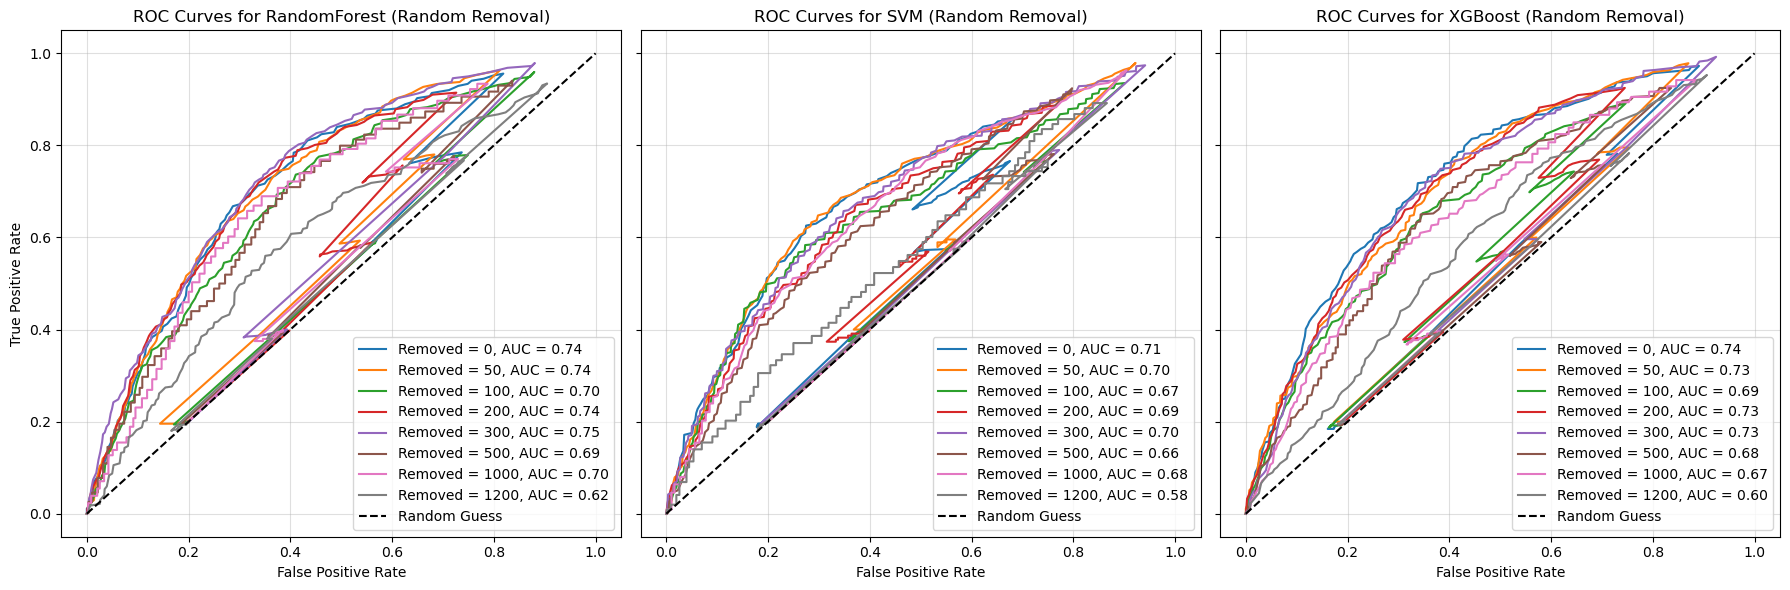

In [3]:
import matplotlib.pyplot as plt

# List of unique models
models = average_results['Model'].unique()

# Set up subplots for side-by-side plotting
fig, axes = plt.subplots(1, len(models), figsize=(18, 6), sharey=True)

# Plot ROC curves for each model
for ax, model_name in zip(axes, models):
    # Filter data for the current model
    model_data = average_results[average_results['Model'] == model_name]
    
    for _, row in model_data.iterrows():
        fpr = row['Avg FPR']
        tpr = row['Avg TPR']
        auc_score = row['Mean Test AUC']
        removed_instances = row['Removed Instances']
        label = f"Removed = {removed_instances}, AUC = {auc_score:.2f}"
        
        # Plot the ROC curve
        ax.plot(fpr, tpr, label=label)
    
    # Add random chance line
    ax.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    
    # Customize each subplot
    ax.set_title(f"ROC Curves for {model_name} (Random Removal)")
    ax.set_xlabel("False Positive Rate")
    if ax == axes[0]:  # Add Y-axis label only for the first subplot
        ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(alpha=0.4)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Experiment 3

To compare cosine similarity and Pearson correlation, check to see how much overlap are there between the ~500 instances removed using the two similarities.

Training Set Size: (1292, 37)
Test Set Size: (324, 37)
Training SVM...
SVM trained successfully.
Training DecisionTree...
DecisionTree trained successfully.
Training RandomForest...
RandomForest trained successfully.
Training GradientBoosting...
GradientBoosting trained successfully.
Training NeuralNetwork...


/opt/anaconda3/envs/research_new/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


NeuralNetwork trained successfully.
Loading SHAP values from shap_values_map.pkl...
SHAP values successfully loaded.
Filtering instances using cosine similarity...
Filtering instances using Pearson correlation...
Number of instances removed by cosine similarity: 529
Number of instances removed by Pearson correlation: 520
Number of overlapping removed instances: 393
Percentage of overlap: 75.58%
Number of instances removed only by cosine similarity: 136
Number of instances removed only by Pearson correlation: 127


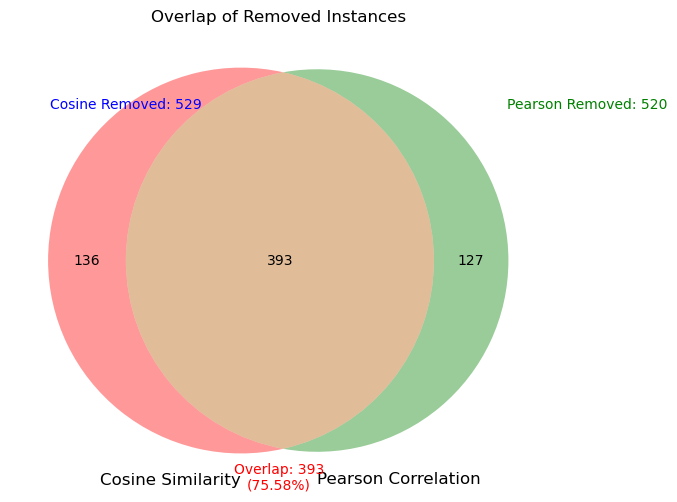

In [7]:
# Experiment 3: Overlap between instances removed by cosine similarity and Pearson correlation

# Load and prepare the ACES data
expression_df, labels_df = load_and_prepare_aces_data(base_path)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = split_data(expression_df, labels_df)
print("Training Set Size:", X_train.shape)
print("Test Set Size:", X_test.shape)

# Train the models
trained_models = train_models(X_train, y_train)

# Load or compute SHAP values
shap_values_map = load_or_compute_shap_values(trained_models, X_train, shap_values_file=SHAP_FILE)

# Ensure indices are properly aligned
print("Filtering instances using cosine similarity...")
retained_indices_cosine = filter_instances_by_cosine_majority_voting(
    shap_values_map, 
    selected_features=SELECTED_FEATURES, 
    pairwise_threshold=0.0
)

print("Filtering instances using Pearson correlation...")
retained_indices_pearson = filter_instances_by_pearson_correlation_majority_voting(
    shap_values_map, 
    selected_features=SELECTED_FEATURES, 
    correlation_threshold=0
)

# Convert retained indices to proper DataFrame indices for consistency
retained_indices_cosine_df = X_train.iloc[retained_indices_cosine].index
retained_indices_pearson_df = X_train.iloc[retained_indices_pearson].index

# Calculate removed indices for both methods
removed_indices_cosine_df = X_train.index.difference(retained_indices_cosine_df)
removed_indices_pearson_df = X_train.index.difference(retained_indices_pearson_df)

# Compute overlap between removed indices
overlap_removed_indices_df = removed_indices_cosine_df.intersection(removed_indices_pearson_df)

# Calculate statistics
num_removed_cosine = len(removed_indices_cosine_df)
num_removed_pearson = len(removed_indices_pearson_df)
num_overlap = len(overlap_removed_indices_df)

# Print results with percentage overlap calculation
if min(num_removed_cosine, num_removed_pearson) > 0:
    overlap_percentage = num_overlap / min(num_removed_cosine, num_removed_pearson) * 100
else:
    overlap_percentage = 0.0

print(f"Number of instances removed by cosine similarity: {num_removed_cosine}")
print(f"Number of instances removed by Pearson correlation: {num_removed_pearson}")
print(f"Number of overlapping removed instances: {num_overlap}")
print(f"Percentage of overlap: {overlap_percentage:.2f}%")

# Analyze differences
only_cosine_removed = removed_indices_cosine_df.difference(removed_indices_pearson_df)
only_pearson_removed = removed_indices_pearson_df.difference(removed_indices_cosine_df)

# Print additional stats
print(f"Number of instances removed only by cosine similarity: {len(only_cosine_removed)}")
print(f"Number of instances removed only by Pearson correlation: {len(only_pearson_removed)}")

# Optional: Visualize overlap using a Venn diagram
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Create the Venn diagram
venn = venn2(
    subsets=(len(only_cosine_removed), len(only_pearson_removed), num_overlap),
    set_labels=("Cosine Similarity", "Pearson Correlation")
)

# Annotate the diagram with additional information
total_removed_cosine = f"Cosine Removed: {num_removed_cosine}"
total_removed_pearson = f"Pearson Removed: {num_removed_pearson}"
overlap_info = f"Overlap: {num_overlap}\n({overlap_percentage:.2f}%)"

# Place annotations near the diagram
plt.text(-0.6, 0.4, total_removed_cosine, fontsize=10, color="blue")
plt.text(0.6, 0.4, total_removed_pearson, fontsize=10, color="green")
plt.text(0, -0.6, overlap_info, fontsize=10, color="red", ha="center")

# Add title and show the plot
plt.title("Overlap of Removed Instances")
plt.show()

Training Set Size: (1292, 37)
Test Set Size: (324, 37)
Training SVM...
SVM trained successfully.
Training DecisionTree...
DecisionTree trained successfully.
Training RandomForest...
RandomForest trained successfully.
Training GradientBoosting...
GradientBoosting trained successfully.
Training NeuralNetwork...


/opt/anaconda3/envs/research_new/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


NeuralNetwork trained successfully.
Loading SHAP values from shap_values_map.pkl...
SHAP values successfully loaded.
Processing threshold: 0.1
Processing threshold: 0.09
Processing threshold: 0.08
Processing threshold: 0.07
Processing threshold: 0.06
Processing threshold: 0.05
Processing threshold: 0.04
Processing threshold: 0.03
Processing threshold: 0.02
Processing threshold: 0.01
Processing threshold: 0.0
Processing threshold: -0.01
Processing threshold: -0.02
Processing threshold: -0.03
Processing threshold: -0.04
Processing threshold: -0.05
Processing threshold: -0.06
Processing threshold: -0.07
Processing threshold: -0.08
Processing threshold: -0.09
Processing threshold: -0.1
Processing threshold: -0.11
Processing threshold: -0.12
Processing threshold: -0.13
Processing threshold: -0.14
Processing threshold: -0.15
Processing threshold: -0.16
Processing threshold: -0.17
Processing threshold: -0.18
Processing threshold: -0.19
Processing threshold: -0.2
    Threshold  Removed Instanc

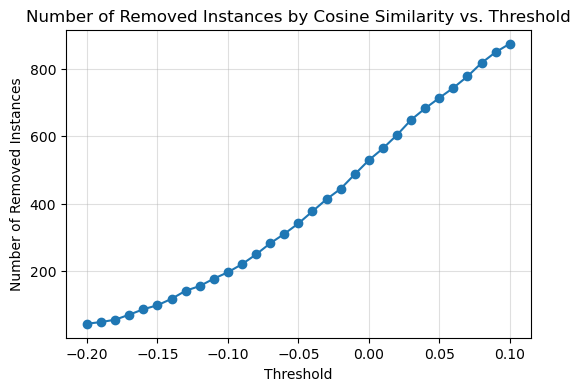

In [8]:
## Removed Instances by Cosine Similarity vs. Threshold

expression_df, labels_df = load_and_prepare_aces_data(base_path)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = split_data(expression_df, labels_df)
print("Training Set Size:", X_train.shape)
print("Test Set Size:", X_test.shape)

# Train the models
trained_models = train_models(X_train, y_train)

# Load or compute SHAP values
shap_values_map = load_or_compute_shap_values(trained_models, X_train, shap_values_file=SHAP_FILE)

thresholds = [round(t, 2) for t in np.arange(0.1, -0.21, -0.01)]  # Generate thresholds from 0.1 to -0.1 with step -0.01

removed_instances_count = []

for threshold in thresholds:
    print(f"Processing threshold: {threshold}")
    retained_indices_cosine = filter_instances_by_cosine_majority_voting(
        shap_values_map, 
        selected_features=SELECTED_FEATURES, 
        pairwise_threshold=threshold
    )
    
    # Calculate removed instances
    removed_count = len(X_train) - len(retained_indices_cosine)
    removed_instances_count.append({
        "Threshold": threshold,
        "Removed Instances": removed_count
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(removed_instances_count)

# Print the results
print(results_df)

# Optionally, visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(results_df['Threshold'], results_df['Removed Instances'], marker='o')
plt.xlabel('Threshold')
plt.ylabel('Number of Removed Instances')
plt.title('Number of Removed Instances by Cosine Similarity vs. Threshold')
plt.grid(alpha=0.4)
plt.show()

## Experminet 4

Identify instances where all metrics (Cosine Similarity, Pearson Correlation) agree or disagree.

In [8]:
# Load and prepare the ACES data
expression_df, labels_df = load_and_prepare_aces_data(base_path)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = split_data(expression_df, labels_df)
print("Training Set Size:", X_train.shape)
print("Test Set Size:", X_test.shape)

# Train the models
trained_models = train_models(X_train, y_train)

# Load or compute SHAP values
shap_values_map = load_or_compute_shap_values(trained_models, X_train, shap_values_file=SHAP_FILE)

# Filtering instances using cosine similarity
print("Filtering instances using cosine similarity...")
retained_indices_cosine = filter_instances_by_cosine_majority_voting(
    shap_values_map, 
    selected_features=SELECTED_FEATURES, 
    pairwise_threshold=0.0
)

# Filtering instances using Pearson correlation
print("Filtering instances using Pearson correlation...")
retained_indices_pearson = filter_instances_by_pearson_correlation_majority_voting(
    shap_values_map, 
    selected_features=SELECTED_FEATURES, 
    correlation_threshold=0.0
)

# Convert retained indices to sets
retained_indices_cosine_set = set(X_train.index[retained_indices_cosine])
retained_indices_pearson_set = set(X_train.index[retained_indices_pearson])

# Calculate removed indices
removed_indices_cosine_set = set(X_train.index) - retained_indices_cosine_set
removed_indices_pearson_set = set(X_train.index) - retained_indices_pearson_set

# Identify overlapping removed indices
overlap_removed_indices = removed_indices_cosine_set & removed_indices_pearson_set

# Print overlap stats
num_overlap = len(overlap_removed_indices)
print(f"Number of overlapping removed instances: {num_overlap}")

# Remove overlapping instances from the training set
overlap_removed_indices_list = list(overlap_removed_indices)
X_train_filtered = X_train.drop(index=overlap_removed_indices_list)
y_train_filtered = y_train.drop(index=overlap_removed_indices_list)

# Print updated dataset sizes
print(f"Updated Training Set Size: {X_train_filtered.shape}")
print(f"Number of instances removed: {num_overlap}")



# Define models and hyperparameter grids
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=RANDOM_STATE),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [5, 10],
            'min_samples_split': [2, 5]
        }
    },
    'SVM': {
        'model': SVC(probability=True, random_state=RANDOM_STATE),
        'param_grid': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(
            random_state=RANDOM_STATE,
            eval_metric='logloss',
            disable_default_eval_metric=True
        ),
        'param_grid': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    }
}

# Initialize results list
results_list = []

# Perform model training and evaluation
for model_name, model_info in models.items():
    print(f"Training {model_name}...")

    model = model_info['model']
    param_grid = model_info['param_grid']

    # Perform Grid Search
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=10,
        n_jobs=-1
    )
    grid_search.fit(X_train_filtered, y_train_filtered)

    # Save the best model
    best_model = grid_search.best_estimator_

    # Compute Train AUC
    y_train_pred_proba = best_model.predict_proba(X_train_filtered)[:, 1]
    train_auc = roc_auc_score(y_train_filtered, y_train_pred_proba)

    # Compute Test AUC
    y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, y_test_pred_proba)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)

    # Append results to the list
    results_list.append({
        "Model": model_name,
        "Train AUC": train_auc,
        "Test AUC": test_auc,
        "Removed Instances": num_overlap,  # Number of overlapping instances removed
        "FPR": fpr.tolist(),
        "TPR": tpr.tolist()
    })

# Convert results list to DataFrame
results_df = pd.DataFrame(results_list)

# Display results
print("\nModel Results:")
print(results_df)

Training Set Size: (1292, 37)
Test Set Size: (324, 37)
Training SVM...
SVM trained successfully.
Training DecisionTree...
DecisionTree trained successfully.
Training RandomForest...
RandomForest trained successfully.
Training GradientBoosting...
GradientBoosting trained successfully.
Training NeuralNetwork...


/opt/anaconda3/envs/research_new/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


NeuralNetwork trained successfully.
Loading SHAP values from shap_values_map.pkl...
SHAP values successfully loaded.
Filtering instances using cosine similarity...
Filtering instances using Pearson correlation...
Number of overlapping removed instances: 393
Updated Training Set Size: (899, 37)
Number of instances removed: 393
Training RandomForest...
Training SVM...
Training XGBoost...

Model Results:
          Model  Train AUC  Test AUC  Removed Instances  \
0  RandomForest   0.947065  0.670079                393   
1           SVM   0.899881  0.650101                393   
2       XGBoost   0.875208  0.665499                393   

                                                 FPR  \
0  [0.0, 0.0, 0.0, 0.0044444444444444444, 0.00444...   
1  [0.0, 0.0044444444444444444, 0.008888888888888...   
2  [0.0, 0.0, 0.0, 0.013333333333333334, 0.013333...   

                                                 TPR  
0  [0.0, 0.010101010101010102, 0.0202020202020202...  
1  [0.0, 0.0, 0.0, 0.03

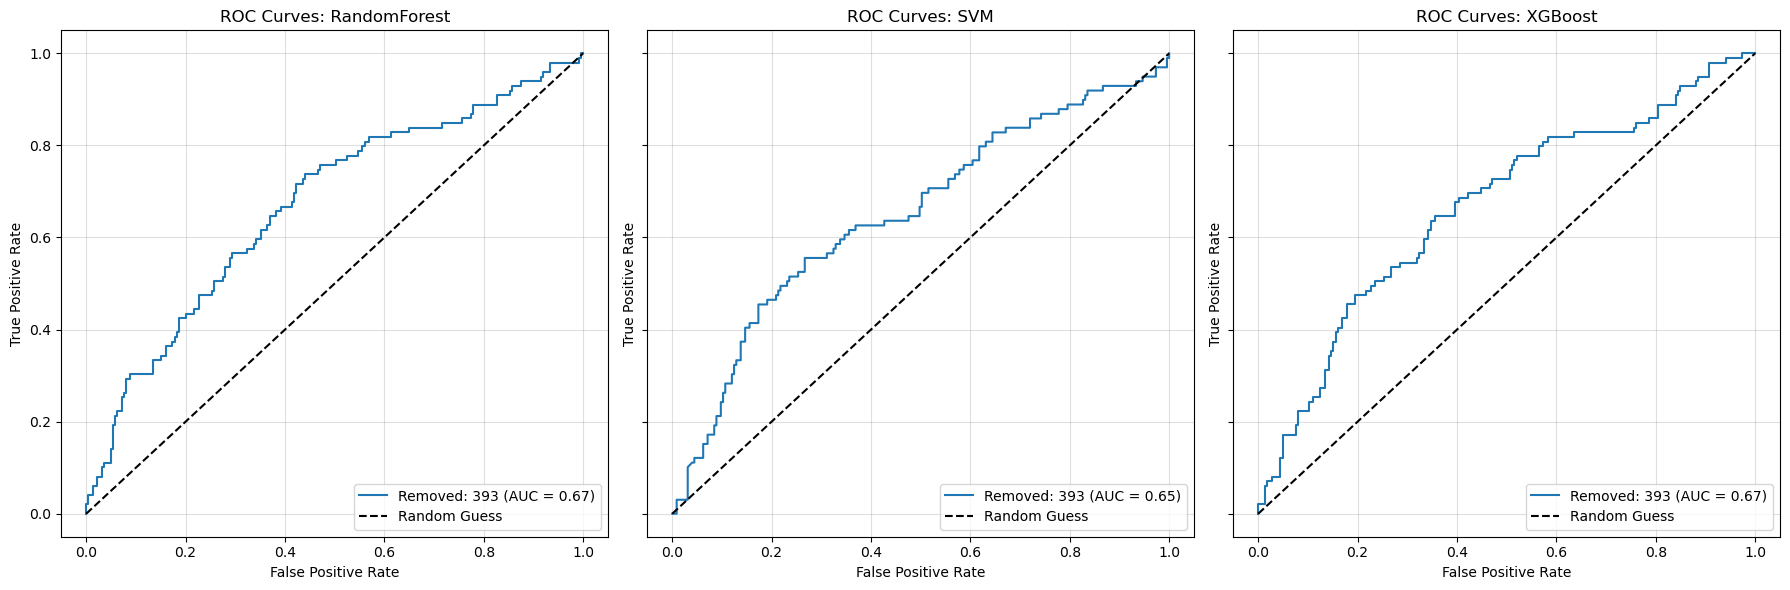

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure FPR and TPR columns are evaluated as Python lists if they are strings
results_df['FPR'] = results_df['FPR'].apply(lambda x: eval(x) if isinstance(x, str) else x)
results_df['TPR'] = results_df['TPR'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# List of unique models
models = results_df['Model'].unique()

# Set up the figure with subplots
fig, axes = plt.subplots(1, len(models), figsize=(18, 6), sharey=True)

# Plot ROC curves for each model
for ax, model_name in zip(axes, models):
    # Filter data for the current model
    model_data = results_df[results_df['Model'] == model_name]
    
    # Plot each curve for the model
    for _, row in model_data.iterrows():
        removed_instances = row['Removed Instances']
        fpr = row['FPR']
        tpr = row['TPR']
        auc_score = row['Test AUC']  # Fetch the AUC score
        
        # Generate labels
        label = f"Removed: {removed_instances} (AUC = {auc_score:.2f})"
        
        # Plot the ROC curve
        ax.plot(fpr, tpr, label=label)
    
    # Add random chance line
    ax.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    
    # Customize each subplot
    ax.set_title(f"ROC Curves: {model_name}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(alpha=0.4)

# Adjust layout
plt.tight_layout()
plt.show()

## KL Divergence

In [ ]:
# Filter instances using KL divergence

# Load and prepare the ACES data
expression_df, labels_df = load_and_prepare_aces_data(base_path)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = split_data(expression_df, labels_df)
print("Training Set Size:", X_train.shape)
print("Test Set Size:", X_test.shape)

# Train the models
trained_models = train_models(X_train, y_train)

# Load or compute SHAP values
shap_values_map = load_or_compute_shap_values(trained_models, X_train, shap_values_file=SHAP_FILE)

retained_indices_kl = filter_instances_by_kl_divergence(
    shap_values_map, 
    selected_features=SELECTED_FEATURES, 
    kl_threshold=0.1
)

# Create filtered datasets
X_train_filtered_kl = X_train.iloc[retained_indices_kl]
y_train_filtered_kl = y_train.iloc[retained_indices_kl]

# Print stats
print(f"Number of retained instances after KL filtering: {len(retained_indices_kl)}")

Training Set Size: (1292, 37)
Test Set Size: (324, 37)
Training SVM...
SVM trained successfully.
Training DecisionTree...
DecisionTree trained successfully.
Training RandomForest...
RandomForest trained successfully.
Training GradientBoosting...
GradientBoosting trained successfully.
Training NeuralNetwork...


/opt/anaconda3/envs/research_new/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


NeuralNetwork trained successfully.
Loading SHAP values from shap_values_map.pkl...
SHAP values successfully loaded.
Total retained instances based on KL Divergence: 1292
Number of retained instances after KL filtering: 1292


In [19]:
# Threshold values for KL divergence filtering
kl_thresholds = [0.05, 0.1, 0.2, 0.3, 0.5, .7, .9, 1]

# Initialize a dictionary to store results
results_kl = []

# Iterate over each threshold
for kl_threshold in kl_thresholds:
    print(f"Filtering instances using KL divergence with threshold {kl_threshold}...")
    
    # Filter instances based on the current threshold
    retained_indices_kl = filter_instances_by_kl_divergence(
        shap_values_map, 
        selected_features=SELECTED_FEATURES, 
        kl_threshold=kl_threshold
    )
    
    # Create filtered datasets
    X_train_filtered_kl = X_train.iloc[retained_indices_kl]
    y_train_filtered_kl = y_train.iloc[retained_indices_kl]
    
    # Calculate statistics
    num_retained = len(retained_indices_kl)
    num_removed = len(X_train) - num_retained

    print(f"Threshold: {kl_threshold}")
    print(f"Number of retained instances: {num_retained}")
    print(f"Number of removed instances: {num_removed}")
    
    # Store results
    results_kl.append({
        "KL Threshold": kl_threshold,
        "Retained Instances": num_retained,
        "Removed Instances": num_removed
    })

# Convert results to a DataFrame for easier viewing
import pandas as pd
results_kl_df = pd.DataFrame(results_kl)

# Display results
print("\nSummary of KL Divergence Filtering:")
print(results_kl_df)

# Optional: Save results to a CSV file
# results_kl_df.to_csv("kl_divergence_filtering_results.csv", index=False)

Filtering instances using KL divergence with threshold 0.05...
Instance 0: Average KL Divergence = 0.0007, Retained = True
Instance 1: Average KL Divergence = 0.0007, Retained = True
Instance 2: Average KL Divergence = 0.0019, Retained = True
Instance 3: Average KL Divergence = 0.0019, Retained = True
Instance 4: Average KL Divergence = 0.0009, Retained = True
Instance 5: Average KL Divergence = 0.0029, Retained = True
Instance 6: Average KL Divergence = 0.0009, Retained = True
Instance 7: Average KL Divergence = 0.0036, Retained = True
Instance 8: Average KL Divergence = 0.0053, Retained = True
Instance 9: Average KL Divergence = 0.0017, Retained = True
Instance 10: Average KL Divergence = 0.0019, Retained = True
Instance 11: Average KL Divergence = 0.0016, Retained = True
Instance 12: Average KL Divergence = 0.0006, Retained = True
Instance 13: Average KL Divergence = 0.0014, Retained = True
Instance 14: Average KL Divergence = 0.0007, Retained = True
Instance 15: Average KL Divergen